# Load Data

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr as corrp
import csv
import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns

df=pd.read_csv('preprocessed_data.csv')
df['choice_numeric'] = [1 if choice == 'space' else 0 for choice in df['choices']]
dfa = df.sort_values(
    by=['sub','planning_depth','decision','current_state','trial_num_within_goal']
)

df['choice_numeric_last'] = (
    dfa
      .groupby(['sub','planning_depth','decision','current_state'])['choice_numeric']
      .shift(1)
)

df['got_to_goal_last'] = (
    dfa
      .groupby(['sub','planning_depth','decision','current_state'])['got_to_goal']
      .shift(1)
)


df['choices_numeric'] = [0 if choice == 'left' else 1 if choice=='right' else 2 for choice in df['choices']]

# Step 1: Filter df where planning_depth == 3 and decision == 1
filtered_df = df[(df['planning_depth'] == 3)]
# Step 2: Group by 'sub' and count the number of 1s in 'choice_numeric'
counts = filtered_df.groupby('sub')['choice_numeric'].apply(lambda x: (x == 1).sum())

# # Step 3: Identify subjects with more than 15 1s
# subjects_to_exclude = counts[counts > 60].index

# # Step 4: Exclude these subjects from df
# df = df[~df['sub'].isin(subjects_to_exclude)]



# Now, identify the first trial within each planning depth for each subject
# To do this, we can use a combination of groupby and transform to mark the first trial's rows
df['is_first_trial'] = df.groupby(['sub', 'planning_depth'])['trial_num'].transform(lambda x: x == x.min())

# Set 'choice_numeric_last' to 0 for all decisions within the first trial of each planning depth
df.loc[df['is_first_trial'] == True, 'choice_numeric_last'] = 0

# Drop the helper column 'is_first_trial' if it's no longer needed
df.drop(columns=['is_first_trial'], inplace=True)

# Ensure there are no NaN values in 'choice_numeric_last'; fill with 0 if any (should be redundant by now)
# Fill NaN values with 0, as these represent the first trial of each goal within each subject
print(df['choice_numeric_last'].value_counts())

df['choice_numeric_last'] = df['choice_numeric_last'].fillna(0)

df['interaction_won_and_metachoice'] = [
    1 if got_to_goal_last == 1 and choice_numeric_last == 1 
    else -1 if got_to_goal_last == 0 and choice_numeric_last == 1 
    else 0 if got_to_goal_last == 0 and choice_numeric_last == 0 
    else 0 if got_to_goal_last == 1 and choice_numeric_last == 0 
    else 0
    for got_to_goal_last, choice_numeric_last in zip(df['got_to_goal_last'], df['choice_numeric_last'])
]

df['got_to_goal_retrieved_cached'] = [
    'Won_Cached' if got_to_goal == 1 and retrieved_cached == 1 
    else 'Lost_Cached' if got_to_goal == 0 and retrieved_cached == 1 
    else 'Won_Novel' if got_to_goal == 0 and retrieved_cached == 0 
    else 'Lost_Novel' if got_to_goal == 1 and retrieved_cached == 0 
    else 0
    for got_to_goal, retrieved_cached in zip(df['got_to_goal'], df['retrieved_cached'])
]

# This solution takes into account the structure of your data, where each subject can have multiple goals
# defined by 'planning_depth', and each goal consists of 20 trials defined by 'trial_num_within_goal'.
# By grouping by both 'subject' and 'planning_depth', the 'choice_numeric_last' column is correctly calculated
# within the context of each goal, ensuring the integrity of the sequence for each goal within each subject.

# Fill NaN values (which will be present for the first trial of each subject) with 0

# This approach 
df=df.reset_index(drop=True)
print(len(df['sub'].unique()))


def calculate_optimal_metacontrol_choice_accounting_for_accuracy(row):
    if row['planning_depth'] == 3:
        if row['got_to_goal']==1:
            return 1 if row['choice_numeric'] == 0 else 0
        else:
            return 0
    elif row['planning_depth'] == 2:
        if row['got_to_goal']==1:
            if row['decision'] == 1:
                return 1 if row['choice_numeric'] == 1 else 0
            elif row['decision'] in [2, 3]:
                return 1 if row['choice_numeric'] == 0 else 0
        else:
            return 0
    elif row['planning_depth'] == 1:
        if row['got_to_goal']==1:
            if row['decision'] in [1, 2]:
                return 1 if row['choice_numeric'] == 1 else 0
            elif row['decision'] == 3:
                return 1 if row['choice_numeric'] == 0 else 0
        else:
            return 0
    else:
        return 0

def calculate_optimal_metacontrol_choice(row):
    if row['planning_depth'] == 3:
        return 1 if row['choice_numeric'] == 0 else 0
    elif row['planning_depth'] == 2:
        if row['decision'] == 1:
            return 1 if row['choice_numeric'] == 1 else 0
        elif row['decision'] in [2, 3]:
            return 1 if row['choice_numeric'] == 0 else 0
        else:
            return 0
    elif row['planning_depth'] == 1:
        if row['decision'] in [1, 2]:
            return 1 if row['choice_numeric'] == 1 else 0
        elif row['decision'] == 3:
            return 1 if row['choice_numeric'] == 0 else 0
        else:
            return 0
    else:
        return 0


def create_optimal_mc(row): #points at which you should relinquish control
    if row['planning_depth'] == 3:
        return 0
    elif row['planning_depth'] == 2:
        if row['decision'] == 1:
            return 1
        elif row['decision'] in [2, 3]:
            return 1 if row['choice_numeric'] == 0 else 0
        else:
            return 0
    elif row['planning_depth'] == 1:
        if row['decision'] in [1, 2]:
            return 1 if row['choice_numeric'] == 1 else 0
        elif row['decision'] == 3:
            return 1 if row['choice_numeric'] == 0 else 0
        else:
            return 0
    else:
        return 0

def create_overcontrol(row): #points at which you should relinquish control
    if row['planning_depth'] == 3:
        if row['optimal_metacontrol_choice']==0:
            return 0
        else:
            return 0
    elif row['planning_depth'] == 2:
        if row['decision'] == 1:
            if row['optimal_metacontrol_choice']==0:
                return 1
            else:
                return -1
        elif row['decision'] in [2, 3]:
            if row['optimal_metacontrol_choice']==0:
                return 0
            else:
                return 0
        
    elif row['planning_depth'] == 1:
        if row['decision'] in [1, 2]:
            if row['optimal_metacontrol_choice']==0:
                return 1
            else:
                return -1
        elif row['decision'] == 3:
            if row['optimal_metacontrol_choice']==0:
                return 0
            else:
                return 0

# Initialize the dictionary
correct_MB_choices = {}

# Assuming df['current_state'] exists and represents the state at the time of making the decision
# Filter the DataFrame for rows where got_to_goal == 1
got_to_goal_df = df[df['got_to_goal'] == 1]

# Populate the dictionary with (planning_depth, decision, current_state) as keys
for _, row in got_to_goal_df.iterrows():
    key = (row['planning_depth'], row['decision'], row['current_state'])
    value = row['choices_numeric']
    # Ensure each key is unique to maintain consistency
    if key not in correct_MB_choices:
        correct_MB_choices[key] = value

def create_MB_decision(row):
    """
    Assigns a value to MB_decision based on the specified logic and the correct_MB_choices dictionary,
    now considering the triplet combination of planning_depth, decision, and current_state.
    
    Parameters:
    - row: a row from the DataFrame.
    
    Returns:
    - The value for MB_decision for the row.
    """
    # Direct conditions
    if row['planning_depth'] == 2 and row['decision'] == 1:
        return 2
    elif row['planning_depth'] == 1 and row['decision'] in [1, 2]:
        return 2
    else:
        # Reference the dictionary with the triplet key
        key = (row['planning_depth'], row['decision'], row['current_state'])
        return correct_MB_choices.get(key, -10)

# Apply the function to each row of the DataFrame
df['MB_decision'] = df.apply(create_MB_decision, axis=1)

    

def create_overplanning(row): #points at which you should relinquish control
    if row['planning_depth'] == 3:
        if row['decision']>1:
            return 1
        else:
            return 0
    elif row['planning_depth'] == 2:
        if row['decision'] == 3:
            return 1
        else:
            return 0
    elif row['planning_depth'] == 1:
        return 0
    else:
        return 0
sd_RT=df['RT'].std()
mean_RT=df['RT'].mean()





# Apply the function to each row
df['optimal_metacontrol_choice'] = df.apply(calculate_optimal_metacontrol_choice, axis=1)
df['optimal_metacontrol_choice_accurate'] = df.apply(calculate_optimal_metacontrol_choice_accounting_for_accuracy, axis=1)

df['over_planning'] = df.apply(create_overplanning, axis=1)
df['over_control'] = df.apply(create_overcontrol, axis=1)

df['optimal_metacontrol_choice_last'] = df.groupby(['sub', 'planning_depth'])['optimal_metacontrol_choice'].shift()

# Now, identify the first trial within each planning depth for each subject
# To do this, we can use a combination of groupby and transform to mark the first trial's rows
df['is_first_trial'] = df.groupby(['sub', 'planning_depth'])['trial_num'].transform(lambda x: x == x.min())

# Set 'choice_numeric_last' to 0 for all decisions within the first trial of each planning depth
df.loc[df['is_first_trial'] == True, 'optimal_metacontrol_choice_last'] = 0

# Drop the helper column 'is_first_trial' if it's no longer needed
df.drop(columns=['is_first_trial'], inplace=True)
# df.drop(columns=['choices'], inplace=True)

# Ensure there are no NaN values in 'choice_numeric_last'; fill with 0 if any (should be redundant by now)
# Fill NaN values with 0, as these represent the first trial of each goal within each subject
df['optimal_metacontrol_choice_last'] = df['optimal_metacontrol_choice_last'].fillna(0)

# Adjusted Step 1: Calculate points from numeric_choice directly, with modification for non-goal-achieving actions
df['points_from_choice'] = df.apply(lambda row: -100 if row['choice_numeric'] == 1 and not row['got_to_goal'] else row['choice_numeric'] * 100, axis=1)

# Step 2: For each trial, determine if got_to_goal was achieved at least once
# This remains unchanged as it correctly calculates points from achieving goals
got_to_goal_per_trial = df.groupby(['sub', 'trial_num'])['got_to_goal'].max().reset_index()
got_to_goal_per_trial['points_from_goal'] = got_to_goal_per_trial['got_to_goal'] * 400
# Merge this back with the original df to associate points_from_goal with each decision
df = df.merge(got_to_goal_per_trial[['sub', 'trial_num', 'points_from_goal']], on=['sub', 'trial_num'], how='left')

# Now, calculate trial_points by summing points_from_choice and points_from_goal for each trial
# This step remains unchanged as it depends on the updated calculation from Step 1
df['trial_points'] = df.groupby(['sub', 'trial_num'])['points_from_choice'].transform('sum') + df['points_from_goal']

# Step 3: Calculate total_points for each subject by summing trial_points
# This step remains unchanged as it correctly sums up the trial points to calculate total points per subject
total_points_per_subject = df.groupby(['sub'])['trial_points'].sum().reset_index(name='total_points')

# If needed, merge total_points back to the original df
# This step ensures each participant's total points are reflected in the original dataframe
df = df.merge(total_points_per_subject[['sub', 'total_points']], on='sub', how='left')

#correct control actions

#transition structure deterministic where red is right, and blue is left



# Deterministic transition structure
deterministic_transitions = {
    ('start', 'red'): 'toothbrush',
    ('start', 'blue'): 'baby',
    ('baby', 'red'): 'bowtie',
    ('baby', 'blue'): 'backpack',
    ('toothbrush', 'red'): 'backpack',
    ('toothbrush', 'blue'): 'car',
    ('backpack', 'blue'): 'zebra',
    ('backpack', 'red'): 'lamp',
    ('bowtie', 'blue'): 'lamp',
    ('bowtie', 'red'): 'knight',
    ('car', 'blue'): 'cat',
    ('car', 'red'): 'lamp'
}

# Recursive helper function to find future states
def find_future_states(state, transitions, visited=None):
    if visited is None:
        visited = set()
    if state in visited:
        return set()
    visited.add(state)
    next_states = {transitions[s] for s in transitions if s[0] == state}
    all_future_states = set(next_states)
    for ns in next_states:
        all_future_states.update(find_future_states(ns, transitions, visited))
    return all_future_states

# To respect the original order of the DataFrame (grouped by decision across all trials),
# we need to build the results array in the same row order as the original DataFrame.

# First, save the original order using an index column
df['original_index'] = df.index

# Recompute correct_control_action values based on trial groupings
correct_action_values = []

# Create a temporary column for correct values, to merge back in order later
temp_df = pd.DataFrame(columns=['original_index', 'correct_control_action'])

for (sub, trial_num), group in df.groupby(['sub', 'trial_num']):
    goal = group['planning_depth'].iloc[0]
    gtg = group['got_to_goal'].iloc[0]
    goal_map = {3: 'cat', 2: 'zebra', 1: 'lamp'}
    target_goal = goal_map[goal]
    state = 'start'

    correct_choices = 0
    control_choices = 0

    for _, row in group.sort_values('decision').iterrows():
        
        state = row['current_state']
        if state != 'start':
            state = state[7:-4]
        decision=row['decision']
        # print(decision)

        choice = row['choices']
        if choice != 'space':
            control_choices += 1
            choice_direction = 'red' if choice == 'right' else 'blue'
            correct_state = deterministic_transitions.get((state, choice_direction))
            if decision==3:
                if gtg:
                    correct_choices+=1

            else:
                
                if target_goal in find_future_states(correct_state, deterministic_transitions):
                    correct_choices += 1
     
    percent_correct = np.nan if control_choices == 0 else correct_choices/control_choices
    # print('percent_correct: {}'.format(percent_correct))
   

    for idx in group.index:
        temp_df.loc[len(temp_df)] = [idx, percent_correct]

# Sort the result to match the original order
temp_df = temp_df.sort_values('original_index')
df = df.sort_values('original_index').drop(columns=['original_index'])

# Merge correct values into main df
df['correct_control_action'] = temp_df['correct_control_action'].values
print(df['correct_control_action'])




# Apply correctness calculation to df
print(df.correct_control_action.value_counts())

df['meta_action']=df['choice_numeric']
def compute_first_meta_action_depth(group):
    """
    For a given group (all rows for a subject at a specific planning depth), 
    considering only decisions 1 and 2, this function finds the very first trial 
    (based on trial order, i.e. trial_num_within_goal) where meta_action == 1 occurred.
    
    It then checks within that trial whether:
      - Only decision 2 had meta_action==1: return -1.
      - Decision 1 had meta_action==1 (or both decisions 1 and 2): return 1.
      - If no meta_action==1 is found at all: return 0.
    
    Parameters:
      group : DataFrame group for one subject and one planning_depth.
    
    Returns:
      int: 1 if the first meta-action was at decision 1 or both decisions on the same trial,
           -1 if it occurred only at decision 2,
           0 if no meta-action==1 occurred in decisions 1 or 2.
    """
    # Consider only rows from decisions 1 and 2
    subset = group[group['decision'].isin([1, 2])]
    if subset.empty:
        return 0

    # Sort by trial number (i.e. within-goal trial) and decision so that decision 1 comes before decision 2 within the same trial
    subset_sorted = subset.sort_values(by=['trial_num_within_goal', 'decision'])
    
    # Find the first occurrence of a meta_action==1 in these rows
    first_meta_rows = subset_sorted[subset_sorted['meta_action'] == 1]
    if first_meta_rows.empty:
        return 0

    # Identify the trial in which the first meta-action occurred
    first_trial = first_meta_rows['trial_num_within_goal'].iloc[0]
    
    # Get all rows for that trial (for decisions 1 and 2)
    trial_rows = subset[subset['trial_num_within_goal'] == first_trial]
    
    # Check if a meta_action==1 occurred on decision 1 and/or decision 2 in that trial
    has_decision1 = ((trial_rows['decision'] == 1) & (trial_rows['meta_action'] == 1)).any()
    has_decision2 = ((trial_rows['decision'] == 2) & (trial_rows['meta_action'] == 1)).any()
    
    # Apply the rules:
    # if both decision 1 and decision 2 have meta_action==1, or if decision 1 has meta_action==1, code as 1.
    if has_decision1:
        return 1
    # else if only decision 2 is flagged in that trial, code as -1.
    elif has_decision2:
        return -1
    else:
        return 0

# Apply the function per subject and planning_depth
# (Assuming that subject identity is in 'sub' and planning depth in 'planning_depth')
# first_meta_action_depth = df.groupby(['sub', 'planning_depth']).apply(compute_first_meta_action_depth).reset_index(name='first_meta_action_depth')

# Merge the results back into the main dataframe so that each row for that subject & planning depth gets the same value
# df = df.merge(first_meta_action_depth, on=['sub', 'planning_depth'], how='left').reset_index(drop=True)

import numpy as np
import pandas as pd

# Define the mbkey dictionary.
mbkey = {
    (3, 1, 'start'): 0, 
    (3, 2, 'images/toothbrush.png'): 0, 
    (3, 2, 'images/baby.png'): -9, 
    (3, 3, 'images/car.png'): 0, 
    (3, 3, 'images/backpack.png'): -9,
    (3, 3, 'images/bowtie.png'): -9, 
    (2, 1, 'start'): 1, 
    (2, 2, 'images/toothbrush.png'): 0,  
    (2, 2, 'images/baby.png'): 0, 
    (2, 3, 'images/backpack.png'): 0,
    (2, 3, 'images/bowtie.png'): -9, 
    (2, 3, 'images/car.png'): -9, 
    (1, 1, 'start'): 1, 
    (1, 2, 'images/toothbrush.png'): 1, 
    (1, 2, 'images/baby.png'): 1, 
    (1, 3, 'images/backpack.png'): 0, 
    (1, 3, 'images/bowtie.png'): 0, 
    (1, 3, 'images/car.png'): 0
}

def compute_switch_order_trial(trial_group):
    """
    For a given trial (i.e. all decision rows for one subject, planning_depth, and trial_num_within_goal),
    determine whether the subject gave up control (meta_action==1) on a decision that came after (i.e. following)
    a decision where they did NOT give up control (meta_action==0).

    The logic is:
      - Within the trial, sort the rows by decision number.
      - If no row shows meta_action==1, return 1 by default.
      - Otherwise, take the first occurrence (lowest decision number) with meta_action==1.
          * If that row is the very first decision in the trial (i.e. no earlier decision taken),
            return 1.
          * If it is not the first decision (i.e. the trial began with at least one control decision, meta_action==0)
            return -1.
    
    Returns:
      int:  1 if the first meta-action occurred on the first decision (or none occurred),
            -1 if the first meta-action occurred after a control decision.
    """
    # Sort the trial rows by decision number
    sorted_trial = trial_group.sort_values('decision')
    
    # If there is no relinquishing control in this trial, we output 1.
    if not (sorted_trial['meta_action'] == 1).any():
        return 1

    # Identify the first row where meta_action==1 (the first giving-up control)
    first_meta_row = sorted_trial[sorted_trial['meta_action'] == 1].iloc[0]
    
    # Compare with the very first decision row in the trial.
    first_decision = sorted_trial.iloc[0]
    if first_meta_row['decision'] == first_decision['decision']:
        return 1   # They gave up control on the very first decision of the trial.
    else:
        return 0  # They had taken control (meta_action==0) on an earlier decision, then later gave up.

def compute_goal_reachability_trial(trial_group, mbkey):
    """
    Determines whether, in a given trial, the subject could have reached the goal from the decision point 
    at which they first gave up control (meta_action==1).
    
    The function works by:
      - Sorting the trial rows by decision number.
      - Finding the first row in which meta_action==1.
      - Using that row’s (planning_depth, decision, current_state) tuple as a key into the mbkey dictionary:
          * If the key is found and its corresponding value is not -9, the trial is rated as 1 (goal reachable).
          * If the value equals -9, the trial is rated as -1 (goal not reachable).
          * If no meta-action occurred in the trial, the function returns np.nan.
    
    Parameters:
      trial_group : DataFrame corresponding to one trial.
      mbkey       : Dictionary with keys of the form (planning_depth, decision, current_state).
    
    Returns:
      int or np.nan:  1 if reachable, -1 if not reachable, np.nan if no meta-action was given in the trial.
    """
    sorted_trial = trial_group.sort_values('decision')
    
    # Select rows where meta_action == 1
    meta_rows = sorted_trial[sorted_trial['meta_action'] == 1]
    if meta_rows.empty:
        return 0  # No relinquishing control in this trial.
    
    # Get the first occurrence of meta_action==1.
    first_meta = meta_rows.iloc[0]
    
    # Construct the key from the relevant columns.
    key = (first_meta['planning_depth'], first_meta['decision'], first_meta['current_state'])
    
    # Look up the key in the mbkey dictionary.
    # If the entry is not -9, then the goal is reachable.
    if key in mbkey:
        return 1 if mbkey[key] != -9 else -1
    else:
        return np.nan  # Key not defined; could also choose a default.

# Now apply these functions to each trial.
# Here we group by subject, planning depth, and trial number (within goal).
trial_groups = ['sub', 'planning_depth', 'trial_num_within_goal']

# Compute the switch order variable.
switch_order = df.groupby(trial_groups).apply(compute_switch_order_trial).reset_index(name='switch_order')
df = df.merge(switch_order, on=trial_groups, how='left')

# Compute the goal reachability variable.
goal_reachability = df.groupby(trial_groups).apply(lambda g: compute_goal_reachability_trial(g, mbkey)).reset_index(name='goal_reachability')
df = df.merge(goal_reachability, on=trial_groups, how='left')

# Optionally, you can check the new columns:
print(df[['sub', 'planning_depth', 'trial_num_within_goal', 'switch_order', 'goal_reachability']].head())


df.to_csv('lmm_fixed.csv')

# df=df[df['RT']<4]


df_memory=pd.read_csv('memory_accuracies_subjects_orig.csv')

df = df.merge(df_memory[['sub','percent_correct']], on='sub', how='left')
df=df.reset_index(drop=True)


# Iterate through each subject
for subject_id, subject_data in df.groupby('sub'):
    # Iterate through each trial for the subject
    for trial_id, trial_data in subject_data.groupby('trial_num'):
        # Check if decision 1 is 0 and decision 2 or 3 is 1
        if ((trial_data['decision'] == 1) & (trial_data['choice_numeric'] == 0)).any() and \
           (((trial_data['decision'] == 2) | (trial_data['decision'] == 3)) & (trial_data['choice_numeric'] == 1)).any():
                # Set 'bad_planning' to 1 for this trial
                df.loc[(df['sub'] == subject_id) & (df['trial_num'] == trial_id), 'bad_planning'] = 1
        # Check if decision 1 is 1 and decision 2 or 3 is 0
        elif ((trial_data['decision'] == 2) & (trial_data['choice_numeric'] == 0)).any() and \
             (((trial_data['trial_num'] == 3)) & (trial_data['choice_numeric'] == 1)).any():
                # Set 'bad_planning' to 1 for this trial
                df.loc[(df['sub'] == subject_id) & (df['trial_num'] == trial_id), 'bad_planning'] = 1
            
df['bad_planning'] = df['bad_planning'].replace([np.nan, np.inf], 0)

# df = df[~df['sub'].isin(bad_planning_subs)]
print(len(df['sub'].unique()))
df['rawRT']=np.exp(df['RT'])

sns.histplot(x='RT',data=df) 
plt.show()
# Print the updated DataFrame
print(df.columns)
df_results2=df
df_results2['control taking'] = [0 if choice == 'space' else 1 for choice in df['choices']]



choice_numeric_last
0.0    21690
1.0     6613
Name: count, dtype: int64
163
0        NaN
1        1.0
2        0.5
3        NaN
4        1.0
        ... 
29335    NaN
29336    1.0
29337    1.0
29338    1.0
29339    NaN
Name: correct_control_action, Length: 29340, dtype: float64
correct_control_action
1.000000    24510
0.000000     1413
0.500000      507
0.333333      444
0.666667      420
Name: count, dtype: int64


C:\Users\sharp\AppData\Local\Temp\ipykernel_26596\2418765824.py:560: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  switch_order = df.groupby(trial_groups).apply(compute_switch_order_trial).reset_index(name='switch_order')
C:\Users\sharp\AppData\Local\Temp\ipykernel_26596\2418765824.py:564: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  goal_reachability = df.groupby(trial_groups).apply(lambda g: compute_goal

                                                 sub  planning_depth  \
0  5608a73fd7def20012b7389d_thisExp_2024-06-24_11...               3   
1  5608a73fd7def20012b7389d_thisExp_2024-06-24_11...               3   
2  5608a73fd7def20012b7389d_thisExp_2024-06-24_11...               3   
3  5608a73fd7def20012b7389d_thisExp_2024-06-24_11...               3   
4  5608a73fd7def20012b7389d_thisExp_2024-06-24_11...               3   

   trial_num_within_goal  switch_order  goal_reachability  
0                      1             1                  1  
1                      2             1                  0  
2                      3             0                 -1  
3                      4             1                  1  
4                      5             1                  0  
163


Index(['Unnamed: 0', 'sub', 'trial_num', 'trial_num_within_goal',
       'current_state', 'decision', 'got_to_goal', 'got_to_goal_last',
       'goal_switch', 'control_regressor', 'RT', 'eligible_decisions_accuracy',
       'retrieved_cached', 'planning_depth', 'delayed_planning', 'choices',
       'worry', 'optimally_delayed', 'optimally_control_choice',
       'optimally_delayed_last', 'choice_numeric', 'choice_numeric_last',
       'choices_numeric', 'interaction_won_and_metachoice',
       'got_to_goal_retrieved_cached', 'MB_decision',
       'optimal_metacontrol_choice', 'optimal_metacontrol_choice_accurate',
       'over_planning', 'over_control', 'optimal_metacontrol_choice_last',
       'points_from_choice', 'points_from_goal', 'trial_points',
       'total_points', 'correct_control_action', 'meta_action', 'switch_order',
       'goal_reachability', 'percent_correct', 'bad_planning', 'rawRT'],
      dtype='object')


In [2]:
print(df[['choice_numeric','choice_numeric_last']].head())

   choice_numeric  choice_numeric_last
0               1                  0.0
1               0                  1.0
2               0                  0.0
3               1                  0.0
4               0                  1.0


In [18]:
print(df['correct_control_action'].value_counts())

correct_control_action
1.000000    24228
0.000000     1539
0.500000      513
0.333333      477
0.666667      438
Name: count, dtype: int64


# Overall performance and its relation to memory

Mean of percent_correct: 0.9274691358024691
Mode of percent_correct: 1.0
                              BetaModel Results                               
Dep. Variable:                      y   Log-Likelihood:                 52.179
Model:                      BetaModel   AIC:                            -98.36
Method:            Maximum Likelihood   BIC:                            -89.09
Date:                Sun, 23 Mar 2025                                         
Time:                        14:36:52                                         
No. Observations:                 162                                         
Df Residuals:                     159                                         
Df Model:                           1                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.1337      0.601     -0.223

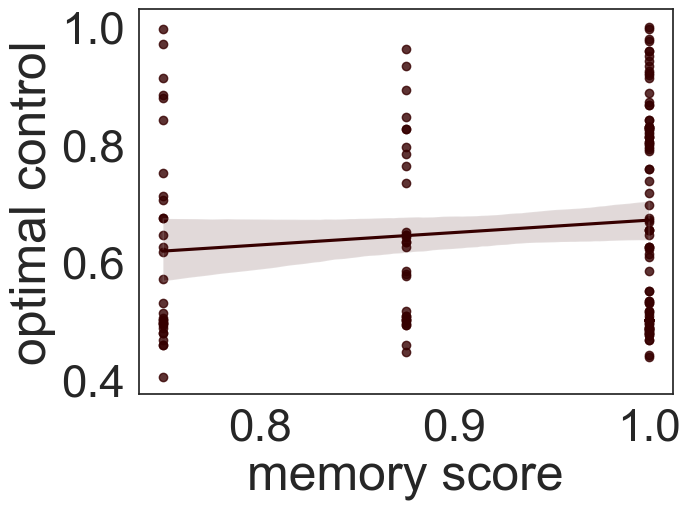

In [14]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr as corrp
from statsmodels.othermod.betareg import BetaModel
import statsmodels.api as sm

# Load the dataset
optimally_delayed_csv = 'optimal_delayed_scores.csv'
df_regression = pd.read_csv(optimally_delayed_csv)
df_regression = df_regression.dropna()

# Calculate and print the mode and mean of the variable percent_correct
mean_percent_correct = df_regression['percent_correct'].mean()
mode_percent_correct = df_regression['percent_correct'].mode()[0]
print(f'Mean of percent_correct: {mean_percent_correct}')
print(f'Mode of percent_correct: {mode_percent_correct}')

# Transform the 'optimal_delayed_score' values
opt_scores = df_regression['optimal_delayed_score'].values
opt_scored_transformed = [x + 0.0001 if x == 0 else x - 0.001 if x == 1 else x for x in opt_scores]

# Prepare the predictors by adding a constant (for the intercept) and the independent variables
X = df_regression[['percent_correct']]
X = sm.add_constant(X)

# Define the dependent variable
y = opt_scored_transformed

# Fit the regression model
model = BetaModel(y, X).fit()

# Display the summary of the regression model
print(model.summary())

# Calculate the Spearman correlation
r, p = corrp(df_regression['percent_correct'], df_regression['optimal_delayed_score'])
print('correl percent correct memory and optimal delayed score: {}, pval:{}'.format(r, p))
sns.set(style='white', font_scale=3, palette='gist_heat')

df_regression['optimally delayed control'] = df_regression['optimal_delayed_score']
df_regression['memory performance'] = df_regression['percent_correct']

# Create the seaborn regression plot with jitter
# Existing imports and previous code remain unchanged...

# Create the seaborn regression plot with jitter
sns.lmplot(x='memory performance', y='optimally delayed control', 
           height=6, aspect=1.3,
           data=df_regression, scatter=True)

# Add a full box around the plot
ax = plt.gca()
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.xlabel('memory score')
plt.ylabel('optimal control')
plt.savefig('memory_optDelay_relationship.png', dpi=300)
plt.show()



In [6]:
print(df.columns)

Index(['Unnamed: 0', 'sub', 'trial_num', 'trial_num_within_goal',
       'current_state', 'decision', 'got_to_goal', 'got_to_goal_last',
       'goal_switch', 'control_regressor', 'RT', 'eligible_decisions_accuracy',
       'retrieved_cached', 'planning_depth', 'delayed_planning', 'choices',
       'worry', 'optimally_delayed', 'optimally_control_choice',
       'optimally_delayed_last', 'choice_numeric', 'choices_numeric',
       'choice_numeric_last', 'interaction_won_and_metachoice',
       'got_to_goal_retrieved_cached', 'MB_decision',
       'optimal_metacontrol_choice', 'optimal_metacontrol_choice_accurate',
       'over_planning', 'over_control', 'optimal_metacontrol_choice_last',
       'points_from_choice', 'points_from_goal', 'trial_points',
       'total_points', 'correct_control_action', 'meta_action', 'switch_order',
       'goal_reachability', 'percent_correct', 'bad_planning', 'rawRT',
       'control taking'],
      dtype='object')


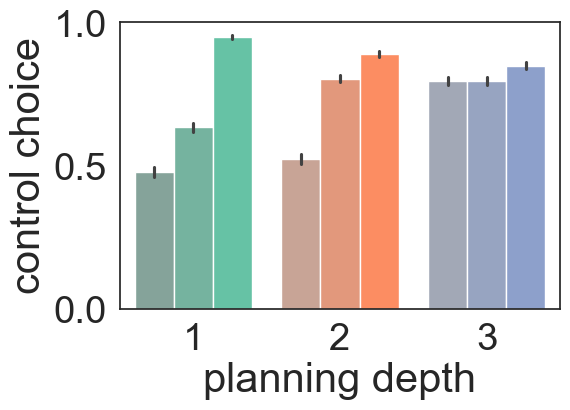

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerTuple


sns.set(style='white', palette='mako', font_scale=2.5, rc=None)

df_results2['trial']=df_results2['trial_num_within_goal']
# df_results2['control taking']=decisions_lamp+decisions_zebra+decisions_cat
# df_results2['planning depth']=['depth=1']*(num_decisions_to_consider*3*len(subs))+['depth=2']*(num_decisions_to_consider*3*len(subs))+['depth=3']*(num_decisions_to_consider*3*len(subs))
ax = sns.barplot(x="planning_depth", y="control taking", hue="decision",data=df_results2)
for bar_group, desaturate_value in zip(ax.containers, [0.33,0.667,1]):
		for bar, color in zip(bar_group, plt.cm.Set2.colors):
			bar.set_facecolor(sns.desaturate(color, desaturate_value))
ax.set(xlabel='planning depth')
ax.set(ylabel='control choice')

labels=[bar_group.get_label() for bar_group in ax.containers]
plt.legend([],[], frameon=False)

plt.tight_layout()
plt.savefig('optimal_control.png',dpi=300)
plt.show()

# from matplotlib.legend_handler import HandlerTuple


# sns.set(style='white', palette='Set2', font_scale=2.2, rc=None)

# # df_results2['decision']=timepoints_tracker
# # df_results2['control taking']=decisions_lamp+decisions_zebra+decisions_cat
# # df_results2['planning depth']=['depth=1']*(num_decisions_to_consider*3*len(subs))+['depth=2']*(num_decisions_to_consider*3*len(subs))+['depth=3']*(num_decisions_to_consider*3*len(subs))
# df_results2['reached goal']=df['got_to_goal']
# ax = sns.lineplot(x="trial", y="reached goal",hue='planning_depth',palette='Set2',ci=68,data=df_results2)
# ax.set_xticks([1, 5, 10, 15, 20]) 

# ax.set(xlabel='trial')

# plt.legend([],[], frameon=False)

# plt.tight_layout()
# plt.savefig('reached_goal.png',dpi=300)
# plt.show()


# ax = sns.lineplot(x="trial", y="correct_control_action",hue='planning_depth',palette='Set2',ci=68,data=df_results2)
# ax.set_xticks([1, 5, 10, 15, 20]) 
# ax.set(ylabel='%corr action')

# ax.set(xlabel='trial')

# plt.legend([],[], frameon=False)

# plt.tight_layout()
# plt.savefig('correct_control_action.png',dpi=300)
# plt.show()


# ax = sns.barplot(x="trial", y="optimal_metacontrol_choice",hue='planning_depth',style='decision',palette='Set2',ci=68,data=df_results2)
# ax.set_xticks([1, 5, 10, 15, 20]) 
# ax.set(ylabel='%corr control choice')
# ax.set(xlabel='trial')

# plt.legend([],[], frameon=False)

# plt.tight_layout()
# plt.savefig('optimal_metacontrol_choice.png',dpi=300)
# plt.show()



C:\Users\sharp\AppData\Local\Temp\ipykernel_17212\3041338228.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_opt['RTz'] = (
C:\Users\sharp\AppData\Local\Temp\ipykernel_17212\3041338228.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_opt['planning depth']=df_opt['planning_depth']
C:\Users\sharp\AppData\Local\Temp\ipykernel_17212\3041338228.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


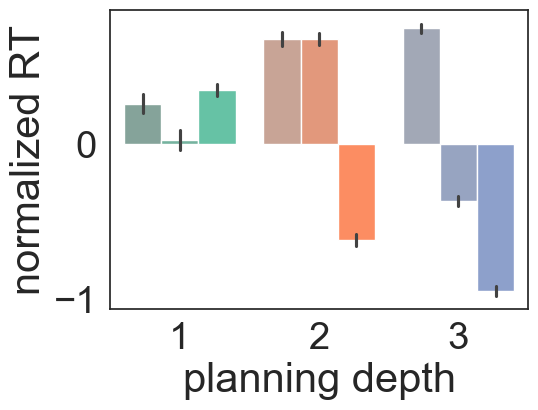

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerTuple

df_opt=df[df['optimally_delayed']==1]
# df_opt=df_opt[df_opt['trial_num_within_goal']<10]
# df_opt.loc[df_opt['decision'] == 1, 'RT'] -= 2

# standardize 'your_var' within each subject × planning_depth
df_opt['RTz'] = (
    df_opt
      .groupby(['sub'])['RT']
      .transform(lambda x: (x - x.mean()) / x.std(ddof=0))
)
# Plotting the barplot with the modified data
sns.set(style='white', font_scale=2.5, palette='Set2')
df_opt['planning depth']=df_opt['planning_depth']
df_opt['normalized RT']=df_opt['RTz']

ax = sns.barplot(x="planning depth", y="normalized RT", hue="decision",palette='Set2',data=df_opt)
for bar_group, desaturate_value in zip(ax.containers, [0.33,0.667,1]):
        for bar, color in zip(bar_group, plt.cm.Set2.colors):
            bar.set_facecolor(sns.desaturate(color, desaturate_value))
labels=[bar_group.get_label() for bar_group in ax.containers]
ax.legend(handles=[tuple(bar_group) for bar_group in ax.containers],loc='lower left',
    labels=['decision=1' if '0' in x else 'decision=2' if '1' in x else 'decision=3' for x in labels],
    prop={'size': 18},
    handlelength=9, handler_map={tuple: HandlerTuple(ndivide=None, pad=0.1)})


plt.legend([],[], frameon=False)


# Saving the plot
plt.tight_layout()
plt.savefig('optimal_RT_by_planningdepth.png', dpi=300,bbox_inches='tight')
plt.show()



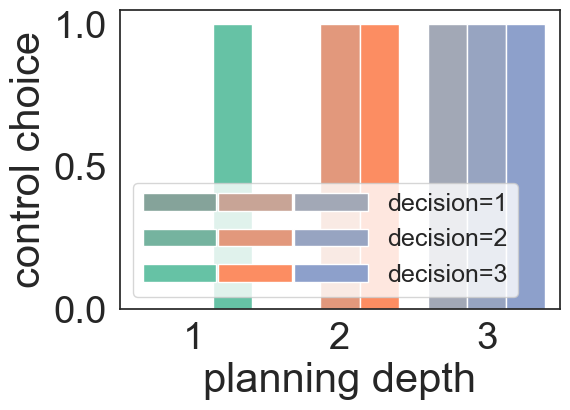

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerTuple

data = {
    "planning depth": [1, 1, 1, 2, 2, 2, 3, 3, 3],
    "decision": [1, 2, 3, 1, 2, 3, 1, 2, 3],
    "control choice": [0, 0, 1, 0, 1, 1, 1, 1, 1]
}

dfp = pd.DataFrame(data)


# Plotting the barplot with the modified data
sns.set(style='white', font_scale=2.5, palette='Set2')
ax = sns.barplot(x="planning depth", y="control choice", hue="decision",data=dfp)
for bar_group, desaturate_value in zip(ax.containers, [0.33,0.667,1]):
        for bar, color in zip(bar_group, plt.cm.Set2.colors):
            bar.set_facecolor(sns.desaturate(color, desaturate_value))
labels=[bar_group.get_label() for bar_group in ax.containers]
ax.legend(handles=[tuple(bar_group) for bar_group in ax.containers],loc='lower left',
    labels=['decision=1' if '0' in x else 'decision=2' if '1' in x else 'decision=3' for x in labels],
    prop={'size': 18},
    handlelength=9, handler_map={tuple: HandlerTuple(ndivide=None, pad=0.1)})




# Saving the plot
plt.tight_layout()
plt.savefig('simulated_optimal_Control_by_planningdepth.png', dpi=300)
plt.show()



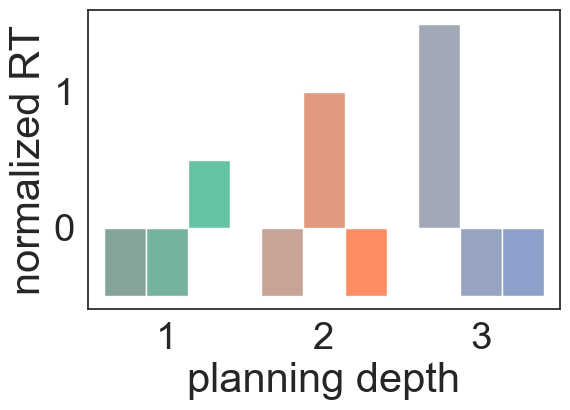

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerTuple

data = {
    "planning depth": [1, 1, 1, 2, 2, 2, 3, 3, 3],
    "decision": [1, 2, 3, 1, 2, 3, 1, 2, 3],
    "normalized RT": [-0.5, -0.5, 0.5, -0.5, 1.0, -0.5, 1.5, -0.5, -0.5]
}

dfp = pd.DataFrame(data)


# Plotting the barplot with the modified data
sns.set(style='white', font_scale=2.5, palette='Set2')
ax = sns.barplot(x="planning depth", y="normalized RT", hue="decision",palette='Set2',data=dfp)
for bar_group, desaturate_value in zip(ax.containers, [0.33,0.667,1]):
        for bar, color in zip(bar_group, plt.cm.Set2.colors):
            bar.set_facecolor(sns.desaturate(color, desaturate_value))
labels=[bar_group.get_label() for bar_group in ax.containers]
ax.legend(handles=[tuple(bar_group) for bar_group in ax.containers],loc='lower left',
    labels=['decision=1' if '0' in x else 'decision=2' if '1' in x else 'decision=3' for x in labels],
    prop={'size': 18},
    handlelength=9, handler_map={tuple: HandlerTuple(ndivide=None, pad=0.1)})


plt.legend([],[], frameon=False)


# Saving the plot
plt.tight_layout()
plt.savefig('simulated_optimal_RT_by_planningdepth.png', dpi=300,bbox_inches='tight')
plt.show()



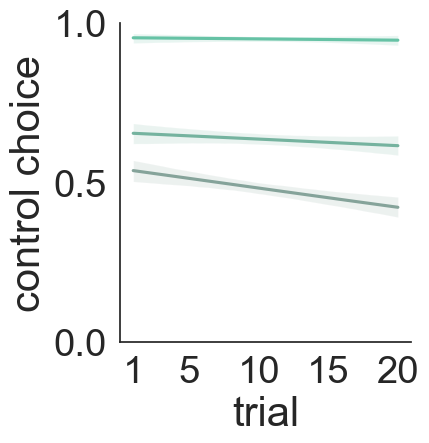

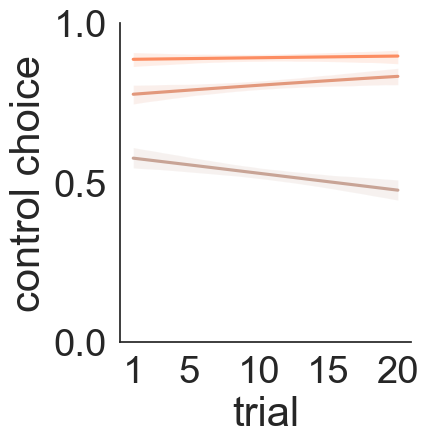

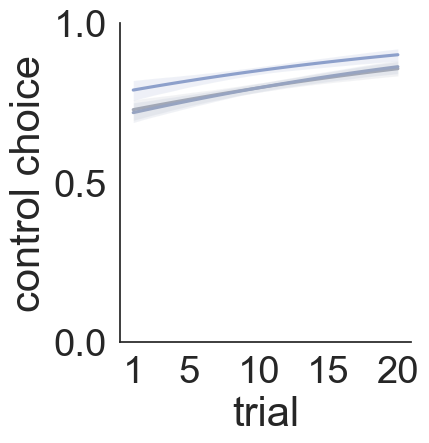

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerTuple

sns.set(style='white', font_scale=2.5, palette='Set2')


# df_results2['RT'] = np.exp(df['RT'])

# # df_results2=df_results2[df_results2['trial_num_within_goal']>10]
# df_results2=df_results2[df_results2['optimally_delayed']==1]
# df_results2=df_results2.reset_index(drop=True)

# # df_results2['normalized RT'] = df_results2.groupby(['decision'])['RT'].transform(lambda x: (x - x.mean())/x.std())
# # non_decision_time=1
# # df_results2['normalized RT'] = [df_results2['RT'][i]-non_decision_time if df_results2['decision'][i]==1 else df_results2['RT'][i] for i in range(len(df_results2))]
# df_results2['normalized RT']= df_results2.groupby(['decision'])['RT'].transform(lambda x: (x - x.mean())/x.std())

# df_results2['planning depth'] = df_results2['planning_depth']
# df_results2['trial number'] = df_results2['trial_num_within_goal']

# ax = sns.barplot(x="planning depth", y="normalized RT", hue="decision", orient='v',palette='Set2',data=df_results2)
# for bar_group, desaturate_value in zip(ax.containers, [0.2,0.6,1]):
#         for bar, color in zip(bar_group, plt.cm.Set2.colors):
#             x=sns.desaturate(color, desaturate_value)
#             print(x)
#             bar.set_facecolor(sns.desaturate(color, desaturate_value))
# labels=[bar_group.get_label() for bar_group in ax.containers]
# ax.legend(handles=[tuple(bar_group) for bar_group in ax.containers],loc='upper right',
#     labels=['decision=1' if '0' in x else 'decision=2' if '1' in x else 'decision=3' for x in labels],
#     prop={'size': 12},
#     handlelength=9, handler_map={tuple: HandlerTuple(ndivide=None, pad=0.1)})

# # plt.legend([],[], frameon=False)

# plt.tight_layout()
# # plt.title('RT for optimally-delayed trials')
# plt.savefig('optimal_planning_RTs.png',dpi=300,bbox_inches='tight')
# plt.show()


# sns.set(style='white', font_scale=2.5, palette='Set2')
# import numpy as np
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# # Assuming df_results2 is already defined
# df_results2=df.copy()
# df_results2['RT'] = np.exp(df['RT'])
# df_results2['planning depth'] = df_results2['planning_depth']
# df_results2['trial'] = df_results2['trial_num_within_goal']

# # plt.figure(figsize=(5, 5))


# # Main plot
# ax = sns.lineplot(x="trial", y="RT", hue='planning depth', err_style="bars",linewidth=2.5, errorbar=("se", 2),palette='Set2', data=df_results2)
# ax.set_xticks([1,5,10,15,20])
# ax.legend_.remove()  # Remove legend from inset
# # plt.title('RT over time')

# sns.set(style='white', font_scale=2.5, palette='Set2')

# # Inset plot
# # inset_ax = inset_axes(ax, width="20%", height="35%", loc='upper center', borderpad=1.5)
# # inset_ax.set_xticks([1,2,3])

# # # Filter data for the first 3 trials
# # df_zoomed = df_results2[df_results2['trial'] <= 3]

# # # Plot the zoomed-in data
# # inset_ax = sns.lineplot(x="trial", y="RT", hue='planning depth', err_style="bars",linewidth=2.5, ci=68,palette='Set2', data=df_zoomed)
# # inset_ax.set_title('Initial Trials')
# # sns.move_legend(inset_ax, "upper left", bbox_to_anchor=(1.50, 3.50))

# # Save the figure
# plt.savefig('RTs_by_time_withOUT_inset.png', dpi=300,bbox_inches='tight')

# plt.show()

# sns.set(style='white', font_scale=1.5, palette='Set2')

# Assuming df_results2 is already defined
df_results2=df.copy()
df_results2['control choice']=(df['choice_numeric']-1)*-1
df_results2['RT'] = np.exp(df['RT'])
df_results2['planning depth'] = df_results2['planning_depth']
df_results2['trial'] = df_results2['trial_num_within_goal']
df_results2['optimally delayed'] = df_results2['optimally_delayed']




# palette = sns.color_palette("Purples")

sns.set(style='white', font_scale=2.5, palette='Set2')

custom_palette1 = [ (0.5208627450980392, 0.6399215686274509, 0.602392156862745),
                  (0.460070588235294, 0.7007137254901961, 0.6248588235294118),
                  (0.4, 0.7607843137254902, 0.6470588235294118)]
custom_palette2 = [  (0.785921568627451, 0.6422745098039215, 0.5866274509803922),
(0.8876823529411766, 0.5973411764705883, 0.48486666666666656),
(0.9882352941176471, 0.5529411764705883, 0.3843137254901961)]
custom_palette3 = [
                  (0.6343921568627452, 0.6589803921568628, 0.7146274509803922),
(0.5934235294117648, 0.643121568627451, 0.7555960784313726),
(0.5529411764705883, 0.6274509803921569, 0.796078431372549)]
# Plot the lines on two facets
ax=sns.lmplot(
    data=df_results2[df_results2['planning_depth']==1],
    x="trial", y="control choice",scatter=False,
    hue="decision", palette=custom_palette1,logistic=True,legend=False)

for axs in ax.axes.flat: 
    axs.set_xticks([1, 5, 10, 15, 20]) 
    axs.set_yticks([0,0.5,1])
plt.savefig('controlTaking_by_time_depth1.png', dpi=300,bbox_inches='tight')

plt.show()

# Plot the lines on two facets
ax=sns.lmplot(
    data=df_results2[df_results2['planning_depth']==2],
    x="trial", y="control choice",logistic=True,scatter=False,
    hue="decision", palette=custom_palette2,legend=False)

for axs in ax.axes.flat: 
    axs.set_xticks([1, 5, 10, 15, 20])
    axs.set_yticks([0,0.5,1])
plt.savefig('controlTaking_by_time_depth2.png', dpi=300,bbox_inches='tight')

plt.show()

# Plot the lines on two facets
ax=sns.lmplot(
    data=df_results2[df_results2['planning_depth']==3],
    x="trial", y="control choice",logistic=True,scatter=False,
    hue="decision", palette=custom_palette3,legend=False)

for axs in ax.axes.flat: 
    axs.set_xticks([1, 5, 10, 15, 20])
    axs.set_yticks([0,0.5,1])
plt.savefig('controlTaking_by_time_depth3.png', dpi=300,bbox_inches='tight')

plt.show()
 


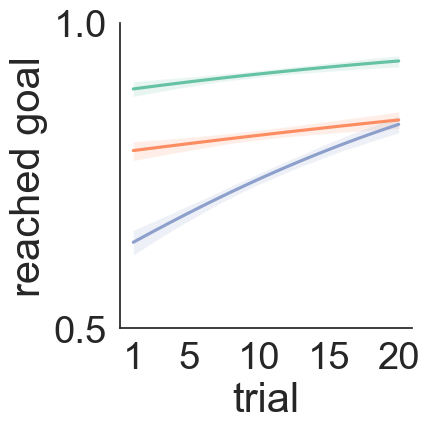

In [25]:
sns.set(style='white', palette='Set2', font_scale=2.5, rc=None)

# df_results2['decision']=timepoints_tracker
# df_results2['control taking']=decisions_lamp+decisions_zebra+decisions_cat
# df_results2['planning depth']=['depth=1']*(num_decisions_to_consider*3*len(subs))+['depth=2']*(num_decisions_to_consider*3*len(subs))+['depth=3']*(num_decisions_to_consider*3*len(subs))
df_results2['trial']=df_results2['trial_num_within_goal']
df_results2['reached goal']=df_results2['got_to_goal']
df_results2['planning depth']=df_results2['planning_depth']

ax=sns.lmplot(
    data=df_results2,
    x="trial", y="reached goal",logistic=True,scatter=False,
    hue="planning_depth", palette='Set2',legend=False)
for axs in ax.axes.flat: 

    axs.set_xticks([1, 5, 10, 15, 20])
    axs.set_yticks([0.5,1])


plt.tight_layout()
plt.savefig('reached_goal_real.png',dpi=300)
plt.show()


/tmp/ipykernel_216497/1449263824.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  sns.lineplot(x='trial_num_within_goal',y='got_to_goal',hue='decision',ci=68,data=df1,palette='Set2')


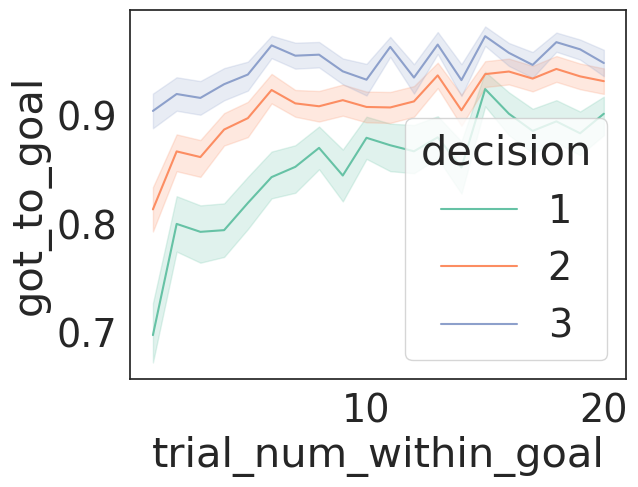

/tmp/ipykernel_216497/1449263824.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  sns.lineplot(x='trial_num_within_goal',y='got_to_goal',hue='planning_depth',ci=68,data=df1,palette='Set2')


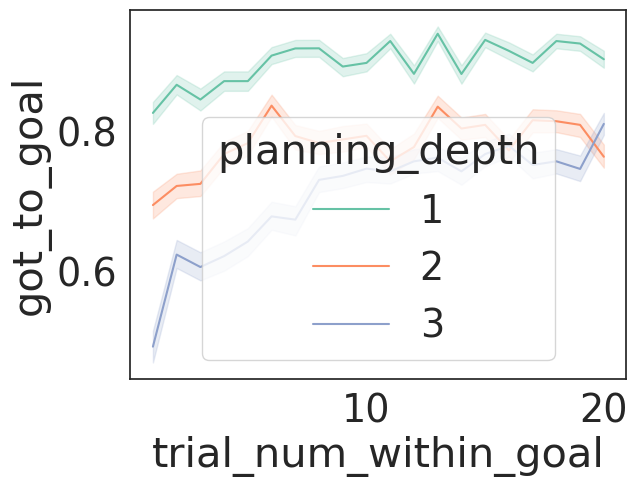

In [8]:
df1=df[df['choice_numeric']==0]
df1=df1[df1['eligible_decisions_accuracy']==1]
sns.lineplot(x='trial_num_within_goal',y='got_to_goal',hue='decision',ci=68,data=df1,palette='Set2')
plt.savefig('accuracy_by_decision_onlycontrolchoices_bar.png',dpi=300)
plt.show()

# df1=df[df['choice_numeric']==0]
df1=df
sns.lineplot(x='trial_num_within_goal',y='got_to_goal',hue='planning_depth',ci=68,data=df1,palette='Set2')
# plt.savefig('accuracy_by_decision_onlycontrolchoices_bar.png',dpi=300)
plt.show()


In [ ]:
import pandas as pd
import arviz as az
from scipy.stats import spearmanr as corrp

# Assuming 'df1' and 'trace_acc' are defined earlier in your script...
trace_acc=az.to_netcdf("choicedata_model_fitted_best.nc")

# Convert subject IDs to indices for group-level parameters
sub_idx, subs = pd.factorize(df['sub'])  

# Save the trace to a NetCDF file for future use

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az

# Assuming `trace_acc` is your InferenceData object and 'decision_coef' is the parameter of interest
# Extracting the posterior samples for 'decision_coef'
posterior_samples = trace_acc.posterior['trial_coef'].values.flatten()
sns.set(font_scale=1.3,style='white')
print(az.summary(trace_acc, var_names=['trial_coef','decision_coef'], hdi_prob=0.95))

# Plotting the KDE of the posterior distribution
sns.kdeplot(posterior_samples, shade=True, color="gray")

# Calculate the 95% HDI
hdi = az.hdi(posterior_samples, hdi_prob=0.95)

# Adding the HDI as a horizontal bar at the bottom
plt.gca().add_patch(plt.Rectangle((hdi[0], 0), hdi[1] - hdi[0], 0.02, color="gold", zorder=10))

# Optionally, adjust the limits and labels of the plot for better visualization
# plt.xlim(min(posterior_samples), max(posterior_samples))
plt.xlim(min(posterior_samples), max(posterior_samples))
plt.xlabel('effect of trial')
plt.ylabel('Density')
plt.title('Posterior distribution with 95% HDI')
plt.savefig('posterior_metacontrol_improve_time.png',dpi=300)
plt.show()


In [4]:
df1=df[df['trial_num_within_goal']==1]
x=df1.groupby('sub')['got_to_goal'].mean()
print(np.mean(x))

0.6973415132924334


Number of first‐of‐state rows: 2504
meta action
control       20223
relinquish     6613
Name: count, dtype: int64
Number of “good” subjects: 163
meta action  got_to_goal_last
control      1.0                 18457
relinquish   1.0                  4215
             0.0                  2398
control      0.0                  1766
Name: count, dtype: int64


C:\Users\sharp\AppData\Local\Temp\ipykernel_32384\1316585537.py:84: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  sns.barplot(


C:\Users\sharp\AppData\Local\Temp\ipykernel_32384\1316585537.py:117: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  sns.lineplot(


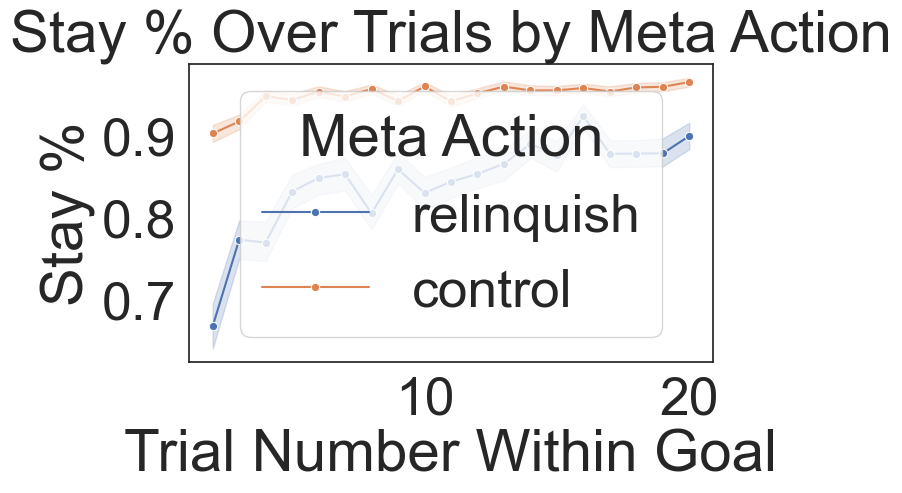

C:\Users\sharp\miniconda3\envs\coding_basic\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  func(*plot_args, **plot_kwargs)
C:\Users\sharp\miniconda3\envs\coding_basic\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  func(*plot_args, **plot_kwargs)
C:\Users\sharp\miniconda3\envs\coding_basic\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  func(*plot_args, **plot_kwargs)
C:\Users\sharp\miniconda3\envs\coding_basic\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  func(*plot_args, **plot_kwargs)
C:\Users\sharp\miniconda3\envs\coding_basic\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

The `ci` paramet

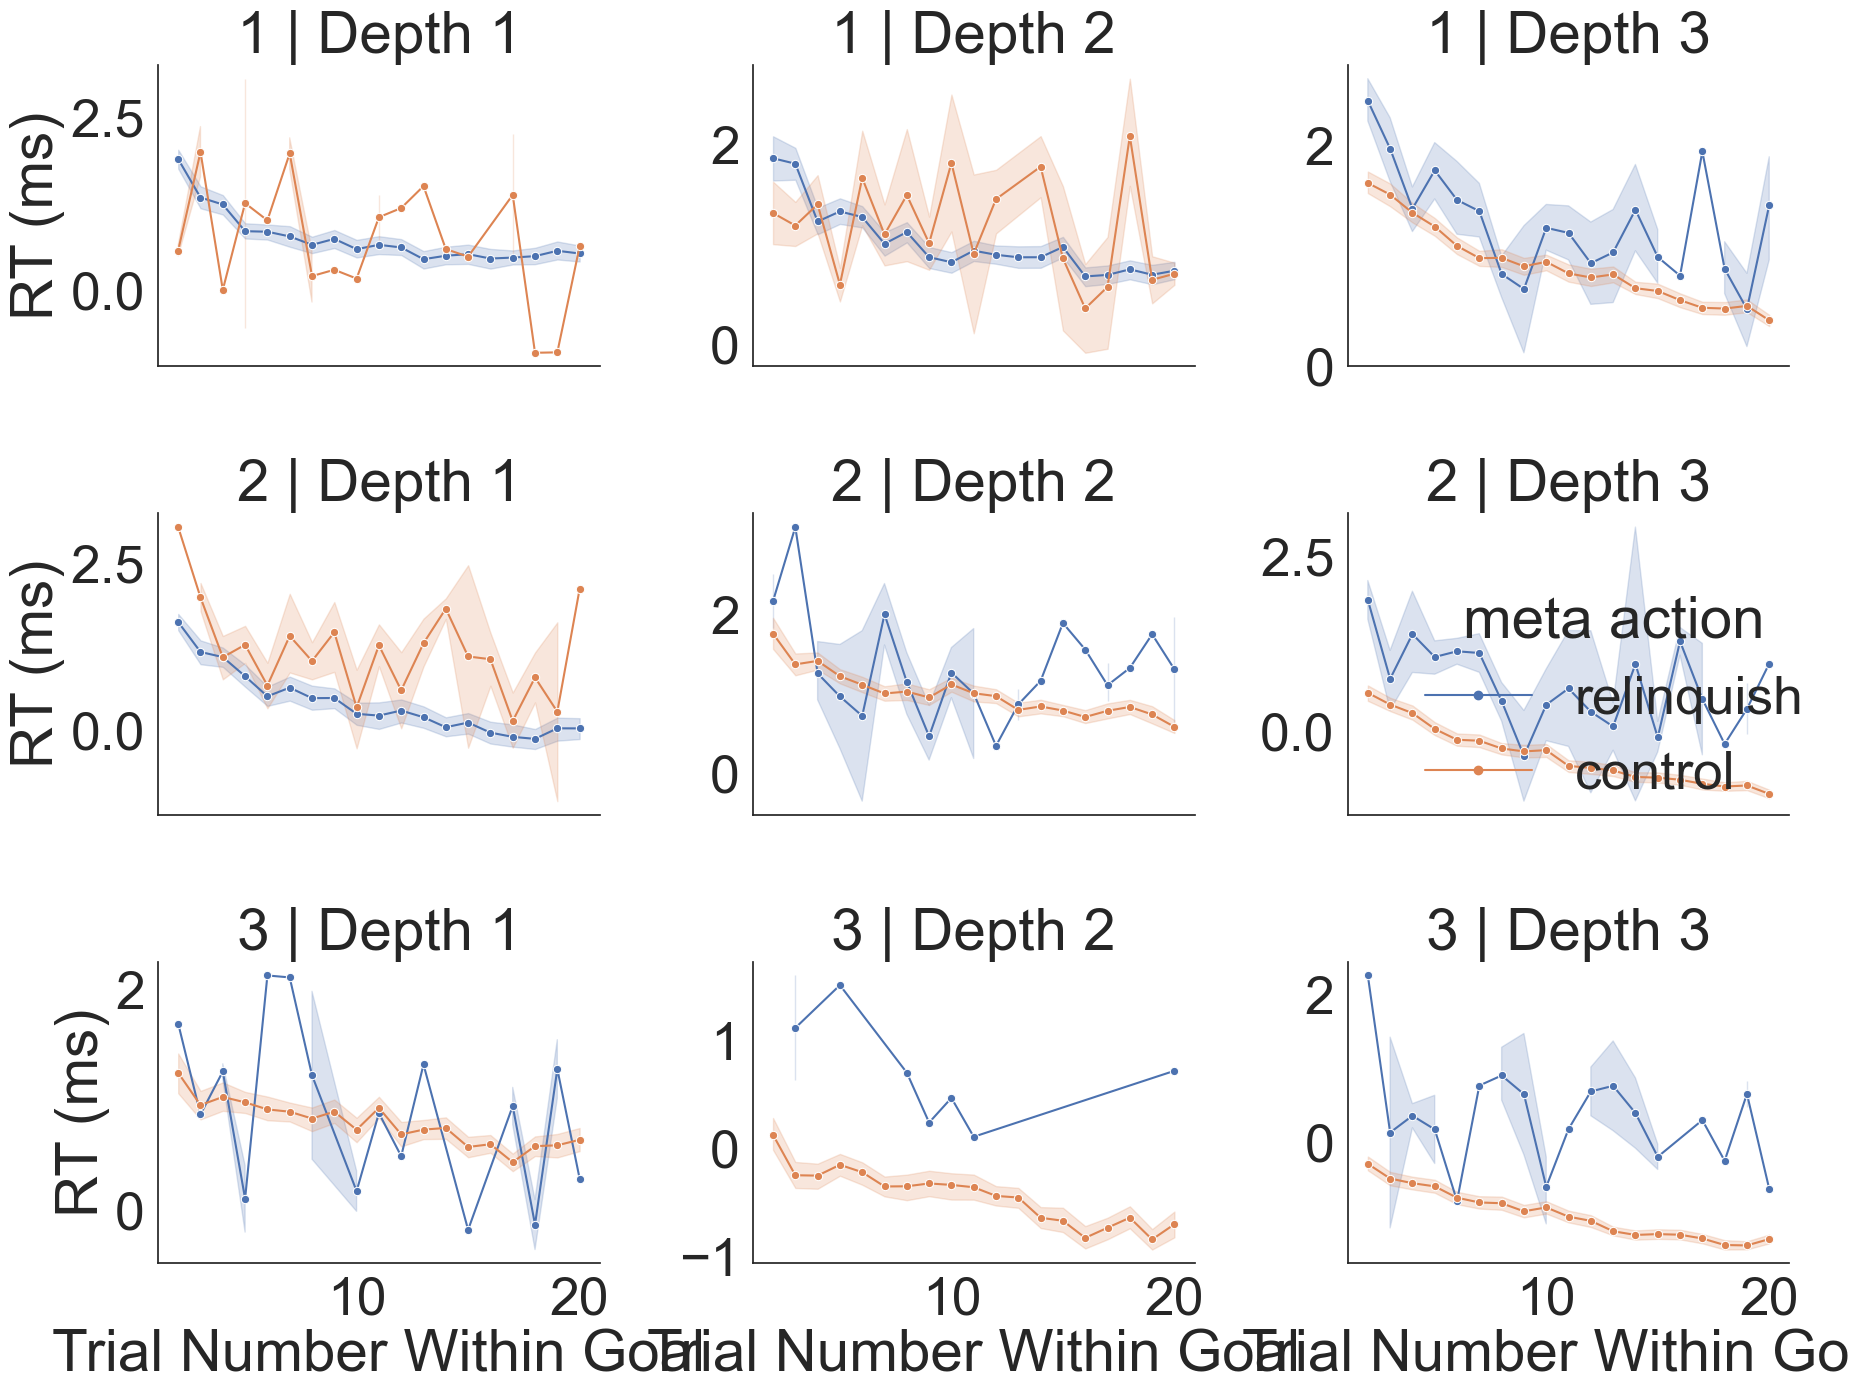

In [37]:
import itertools

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load & sort
dfp = df.copy()
sort_cols = ['sub', 'planning_depth', 'decision', 'current_state', 'trial_num_within_goal']
dfp = dfp.sort_values(by=sort_cols)

# 2. Compute “last‐of‐state” columns by shifting within each (sub, planning_depth, decision, current_state) group
group_cols = sort_cols[:-1]
dfp['choice_numeric_last'] = dfp.groupby(group_cols)['choice_numeric'].shift(1)
dfp['got_to_goal_last'] = dfp.groupby(group_cols)['got_to_goal'].shift(1)

n_first = dfp['choice_numeric_last'].isna().sum()
print(f'Number of first‐of‐state rows: {n_first}')

# 3. Compute optimal control choice (using your existing function)
dfp['optimally_control_choice'] = dfp.apply(calculate_optimal_metacontrol_choice, axis=1)

# 4. Drop rows without a previous choice, reset index
dfp = dfp.dropna(subset=['choice_numeric_last']).reset_index(drop=True)

# 5. Stay vs. switch: 1 if same as last time, else 0
dfp['meta_action_stay'] = (dfp['choice_numeric'] == dfp['choice_numeric_last']).astype(int)

# 6. Map to labels
dfp['reinforcement'] = dfp['got_to_goal_last'].map({1: 'reward', 0: 'no reward'})
dfp['meta action'] = dfp['choice_numeric_last'].map({1: 'relinquish', 0: 'control'})

print(dfp['meta action'].value_counts())

# 7. Select only subjects who meet your condition
good_subs = (
    dfp.groupby('sub')
      .filter(lambda x: (x['got_to_goal'] > -1).all() and (x['optimally_control_choice'].sum() > -1))
      ['sub']
      .unique()
)
dfp_sel = dfp[dfp['sub'].isin(good_subs) & (dfp['trial_num_within_goal'] > 1)]

print(f'Number of “good” subjects: {len(dfp_sel["sub"].unique())}')
print(dfp_sel[['meta action', 'got_to_goal_last']].value_counts())

# 8. Bar‐plot stay % by meta action and reinforcement, including missing combos at –1
order = ['control', 'relinquish']
hue_order = ['no reward', 'reward']

# Build count table for annotations
counts = (
    dfp_sel
    .groupby(['meta action', 'reinforcement'])
    .size()
    .unstack(fill_value=0)
    .reindex(index=order, columns=hue_order, fill_value=0)
)

# Add placeholders so seaborn draws a bar at –1 for any missing combo
placeholders = []
for action, reinf in itertools.product(order, hue_order):
    if counts.loc[action, reinf] == 0:
        placeholders.append({
            'sub': None,
            'planning_depth': None,
            'decision': None,
            'current_state': None,
            'trial_num_within_goal': None,
            'choice_numeric': None,
            'got_to_goal': None,
            'choice_numeric_last': None,
            'got_to_goal_last': None,
            'optimally_control_choice': None,
            'meta_action_stay': -1,
            'reinforcement': reinf,
            'meta action': action
        })
if placeholders:
    dfp_sel = pd.concat([dfp_sel, pd.DataFrame(placeholders)], ignore_index=True)

# Plot
plt.figure(figsize=(8, 6))
sns.barplot(
    x='meta action',
    y='meta_action_stay',
    hue='reinforcement',
    data=dfp_sel,
    palette=['red', 'green'],
    ci=68,
    order=order,
    hue_order=hue_order
)

# Clean labels
plt.xlabel('')
plt.ylabel('Stay %')
plt.yticks([0,0.2,0.4,0.6,0.8,1.0])
plt.legend([], [], frameon=False)

# Save & show
plt.savefig('stayPlot_ALLPerformingSubjects.png', bbox_inches='tight', dpi=300)
plt.show()

# --- After you have dfp_sel ready from the previous steps ---

# 9. Compute mean stay % by trial number and meta action
stay_by_trial = (
    dfp_sel
    .groupby(['trial_num_within_goal', 'meta action'])['meta_action_stay']
    .mean()
    .reset_index()
)

# 10. Plot
plt.figure(figsize=(8, 6))
sns.lineplot(
    x='trial_num_within_goal',
    y='meta_action_stay',
    hue='meta action',
    data=dfp_sel,
    marker='o',
    ci=68,
)

plt.xlabel('Trial Number Within Goal')
plt.ylabel('Stay %')

plt.title('Stay % Over Trials by Meta Action')
plt.legend(title='Meta Action')
plt.tight_layout()
plt.show()

import matplotlib.pyplot as plt
import seaborn as sns

# filter as before
dfp_t = dfp_sel[dfp_sel['optimally_delayed'] == 1]

# create a FacetGrid of line‐plots
g = sns.relplot(
    data=dfp_t,
    x='trial_num_within_goal',
    y='RT',
    hue='meta action',
    kind='line',
    col='planning_depth',
    row='decision',
    marker='o',
    ci=68,
    facet_kws=dict(
        sharex=True,    # share the x‐axis across columns
        sharey=False    # allow each row to scale y independently if you like
    )
)

# axis labels
g.set_axis_labels("Trial Number Within Goal", "RT (ms)")

# customize titles: left side = decision, top = depth
g.set_titles(row_template="{row_name}", col_template="Depth {col_name}")

# move legend out or remove if you don’t need it

plt.tight_layout()
plt.show()



# simulated data analysis

Number of first‐of‐state rows: 2504
meta action
control       19339
relinquish     7497
Name: count, dtype: int64
Number of “good” subjects: 163
meta action  got_to_goal_last
control      1.0                 18158
relinquish   1.0                  6056
             0.0                  1441
control      0.0                  1181
Name: count, dtype: int64


C:\Users\sharp\AppData\Local\Temp\ipykernel_26596\2622122459.py:85: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  sns.barplot(


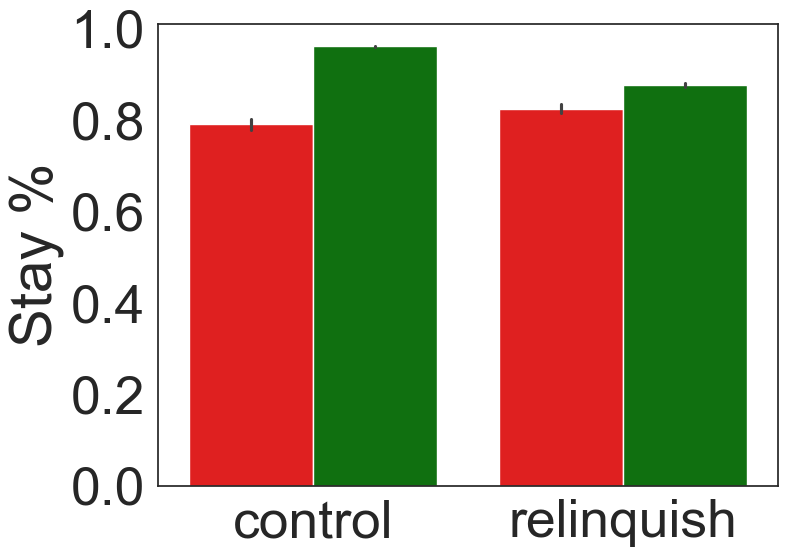

C:\Users\sharp\AppData\Local\Temp\ipykernel_26596\2622122459.py:117: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  sns.lineplot(


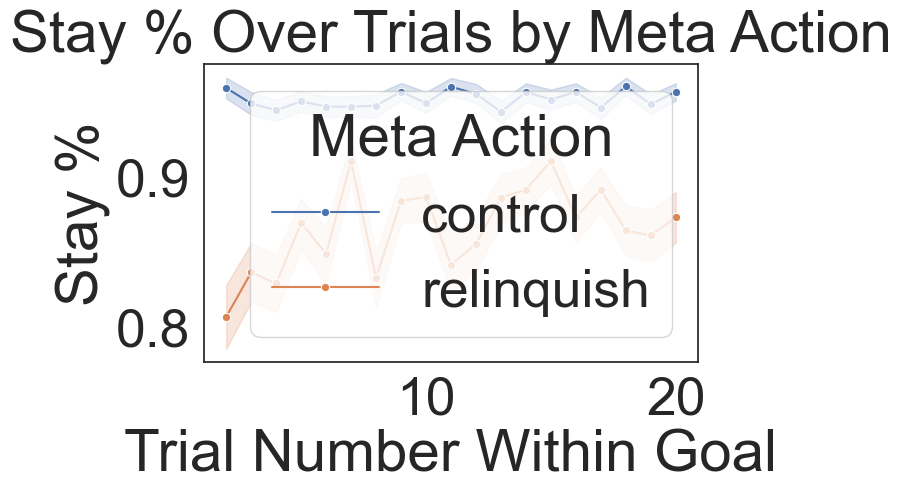

In [9]:
import itertools

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load & sort
sns.set(style='white',font_scale=3.5)
dfa = pd.read_csv('simulated_data.csv')
sort_cols = ['sub', 'planning_depth', 'decision', 'current_state', 'trial_num_within_goal']
dfa = dfa.sort_values(by=sort_cols)

# 2. Compute “last‐of‐state” columns by shifting within each (sub, planning_depth, decision, current_state) group
group_cols = sort_cols[:-1]
dfa['choice_numeric_last'] = dfa.groupby(group_cols)['choice_numeric'].shift(1)
dfa['got_to_goal_last'] = dfa.groupby(group_cols)['got_to_goal'].shift(1)

n_first = dfa['choice_numeric_last'].isna().sum()
print(f'Number of first‐of‐state rows: {n_first}')

# 3. Compute optimal control choice (using your existing function)
dfa['optimally_control_choice'] = dfa.apply(calculate_optimal_metacontrol_choice, axis=1)

# 4. Drop rows without a previous choice, reset index
dfa = dfa.dropna(subset=['choice_numeric_last']).reset_index(drop=True)

# 5. Stay vs. switch: 1 if same as last time, else 0
dfa['meta_action_stay'] = (dfa['choice_numeric'] == dfa['choice_numeric_last']).astype(int)

# 6. Map to labels
dfa['reinforcement'] = dfa['got_to_goal_last'].map({1: 'reward', 0: 'no reward'})
dfa['meta action'] = dfa['choice_numeric_last'].map({1: 'relinquish', 0: 'control'})

print(dfa['meta action'].value_counts())

# 7. Select only subjects who meet your condition
good_subs = (
    dfa.groupby('sub')
      .filter(lambda x: (x['got_to_goal'] > -1).all() and (x['optimally_control_choice'].sum() > -1))
      ['sub']
      .unique()
)
dfa_sel = dfa[dfa['sub'].isin(good_subs) & (dfa['trial_num_within_goal'] > 1)]

print(f'Number of “good” subjects: {len(dfa_sel["sub"].unique())}')
print(dfa_sel[['meta action', 'got_to_goal_last']].value_counts())

# 8. Bar‐plot stay % by meta action and reinforcement, including missing combos at –1
order = ['control', 'relinquish']
hue_order = ['no reward', 'reward']

# Build count table for annotations
counts = (
    dfa_sel
    .groupby(['meta action', 'reinforcement'])
    .size()
    .unstack(fill_value=0)
    .reindex(index=order, columns=hue_order, fill_value=0)
)

# Add placeholders so seaborn draws a bar at –1 for any missing combo
placeholders = []
for action, reinf in itertools.product(order, hue_order):
    if counts.loc[action, reinf] == 0:
        placeholders.append({
            'sub': None,
            'planning_depth': None,
            'decision': None,
            'current_state': None,
            'trial_num_within_goal': None,
            'choice_numeric': None,
            'got_to_goal': None,
            'choice_numeric_last': None,
            'got_to_goal_last': None,
            'optimally_control_choice': None,
            'meta_action_stay': -1,
            'reinforcement': reinf,
            'meta action': action
        })
if placeholders:
    dfa_sel = pd.concat([dfa_sel, pd.DataFrame(placeholders)], ignore_index=True)

# Plot
plt.figure(figsize=(8, 6))
sns.barplot(
    x='meta action',
    y='meta_action_stay',
    hue='reinforcement',
    data=dfa_sel,
    palette=['red', 'green'],
    ci=68,
    order=order,
    hue_order=hue_order
)

# Clean labels
plt.xlabel('')
plt.ylabel('Stay %')
plt.yticks([0,0.2,0.4,0.6,0.8,1.0])
plt.legend([], [], frameon=False)

# Save & show
plt.savefig('stayPlot_ALLPerformingSubjects_SIM.png', bbox_inches='tight', dpi=300)
plt.show()

# --- After you have dfa_sel ready from the previous steps ---

# 9. Compute mean stay % by trial number and meta action
stay_by_trial = (
    dfa_sel
    .groupby(['trial_num_within_goal', 'meta action'])['meta_action_stay']
    .mean()
    .reset_index()
)

plt.figure(figsize=(8, 6))
sns.lineplot(
    x='trial_num_within_goal',
    y='meta_action_stay',
    hue='meta action',
    data=dfa_sel,
    marker='o',
    ci=68,
)

plt.xlabel('Trial Number Within Goal')
plt.ylabel('Stay %')
plt.title('Stay % Over Trials by Meta Action')
plt.legend(title='Meta Action')
plt.tight_layout()
plt.show()


In [6]:
import pymc as pm
import arviz as az
import numpy as np
import pandas as pd
import warnings

# Assuming 'df_RT' is already prepared and loaded
df_RT = df.copy()
# df_RT = df[df['trial_num_within_goal'] != 1]
# df_RT['mean_optimal_delayed']=df_RT.groupby('sub')['optimally_delayed'].transform('mean')
# df_RT=df_RT[df_RT['mean_optimal_delayed']>0.34]

warnings.filterwarnings("ignore")

# Factorize 'sub' to use as indices for group-level effects
sub_idx, subs = pd.factorize(df_RT['sub'])
subject_median_rt = df_RT.groupby('sub')['RT'].transform('median')

# Prepare data for modeling
RT = df_RT['RT'].values # Assuming RT is the response variable you're modeling
delayed_planning = df_RT['delayed_planning'].values
trial_num_v = ((df_RT['trial_num_within_goal'].values-21)/20.0)
goalswitch = df_RT['goal_switch'].values
decision = df_RT['decision'].values-2
overplan = df_RT['over_planning'].values
planning_depth = df_RT['planning_depth'].values-2
control_effect = df_RT['control_regressor'].values

interaction = delayed_planning * trial_num_v  # Interaction term

with pm.Model() as model_pymc:
    # Priors for fixed effects
    intercept = pm.Normal('intercept', mu=0, sigma=2)
    coef_delayed_planning = pm.Normal('coef_delayed_planning', mu=0, sigma=2)
    coef_trial_num = pm.Normal('coef_trial_num', mu=0, sigma=2)
    coef_goalswitch = pm.Normal('coef_goalswitch', mu=0, sigma=2)
    coef_decision = pm.Normal('coef_decision', mu=0, sigma=2)
    coef_planning_depth = pm.Normal('coef_planning_depth', mu=0, sigma=2)
    coef_c = pm.Normal('coef_c', mu=0, sigma=2)
    coef_interaction = pm.Normal('coef_interaction', mu=0, sigma=2)
    # error_var = pm.HalfNormal('error_c', 2)
    
    # Priors for random effects
    sigma_sub = pm.HalfNormal('sigma_sub', 2)
    intercept_sub = pm.Normal('intercept_sub', mu=0, sigma=sigma_sub, shape=len(subs))
    
    sigma_slope_dp = pm.HalfNormal('sigma_slope_dp', 2)
    slope_sub_dp = pm.Normal('slope_sub_dp', mu=0, sigma=sigma_slope_dp, shape=len(subs))
    
    sigma_slope_c = pm.HalfNormal('sigma_slope_c', 2)
    slope_sub_c = pm.Normal('slope_sub_c', mu=0, sigma=sigma_slope_c, shape=len(subs))

    sigma_slope_gs = pm.HalfNormal('sigma_slope_gs', 2)
    slope_sub_gs = pm.Normal('slope_sub_gs', mu=0, sigma=sigma_slope_gs, shape=len(subs))

    sigma_slope_d = pm.HalfNormal('sigma_slope_d', 2)
    slope_sub_d = pm.Normal('slope_sub_d', mu=0, sigma=sigma_slope_d, shape=len(subs))

    sigma_slope_pd = pm.HalfNormal('sigma_slope_pd', 2)
    slope_sub_pd = pm.Normal('slope_sub_pd', mu=0, sigma=sigma_slope_pd, shape=len(subs))

    sigma_slope_tn = pm.HalfNormal('sigma_slope_tn', 2)
    slope_sub_tn = pm.Normal('slope_sub_tn', mu=0, sigma=sigma_slope_tn, shape=len(subs))

    sigma_slope_interaction = pm.HalfNormal('sigma_slope_interaction', 2)
    slope_sub_interaction = pm.Normal('slope_sub_interaction', mu=0, sigma=sigma_slope_interaction, shape=len(subs))
    
    # Linear model
    mu = (intercept + intercept_sub[sub_idx] + 
          (coef_delayed_planning + slope_sub_dp[sub_idx]) * delayed_planning + 
          (coef_trial_num + slope_sub_tn[sub_idx]) * trial_num_v + 
          (coef_goalswitch + slope_sub_gs[sub_idx]) * goalswitch + 
          (coef_decision + slope_sub_d[sub_idx]) * decision + 
          (coef_c + slope_sub_c[sub_idx]) * control_effect + 
          (coef_planning_depth + slope_sub_pd[sub_idx]) * planning_depth + 
          (coef_interaction + slope_sub_interaction[sub_idx]) * interaction)
    
    # Assuming RT is continuous; use appropriate distribution if otherwise
    RT_obs = pm.Normal('RT_obs', mu=mu, sigma=1, observed=RT)
    
    # Inference
    trace3 = pm.sample(draws=1000, tune=1000, target_accept=0.80)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, coef_delayed_planning, coef_trial_num, coef_goalswitch, coef_decision, coef_planning_depth, coef_c, coef_interaction, sigma_sub, intercept_sub, sigma_slope_dp, slope_sub_dp, sigma_slope_c, slope_sub_c, sigma_slope_gs, slope_sub_gs, sigma_slope_d, slope_sub_d, sigma_slope_pd, slope_sub_pd, sigma_slope_tn, slope_sub_tn, sigma_slope_interaction, slope_sub_interaction]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 556 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [2]:
trace3=az.from_netcdf("RTdata_model_fitted_withintrial2.nc") 
# az.to_netcdf(trace3,"RTdata_model_fitted_withintrial2.nc")
print(trace3.posterior.coef_trial_num)
print(az.summary(trace3, var_names=['intercept','coef_trial_num','coef_delayed_planning','coef_trial_num','coef_goalswitch',
                                    'coef_decision','coef_planning_depth','coef_c',
                                    'coef_interaction'], hdi_prob=0.95))


<xarray.DataArray 'coef_trial_num' (chain: 4, draw: 1000)> Size: 32kB
[4000 values with dtype=float64]
Coordinates:
  * chain    (chain) int64 32B 0 1 2 3
  * draw     (draw) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
                        mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
intercept             -0.588  0.050    -0.684     -0.492      0.002    0.001   
coef_trial_num        -1.464  0.050    -1.560     -1.364      0.001    0.001   
coef_delayed_planning  0.367  0.039     0.287      0.442      0.001    0.001   
coef_goalswitch        0.159  0.013     0.133      0.185      0.000    0.000   
coef_decision         -0.540  0.033    -0.607     -0.476      0.001    0.001   
coef_planning_depth   -0.107  0.021    -0.150     -0.067      0.000    0.000   
coef_c                -0.129  0.042    -0.211     -0.045      0.001    0.001   
coef_interaction       0.240  0.043     0.158      0.327      0.001    0.001   

                       ess_bulk  ess_tail  r_h

C:\Users\sharp\AppData\Local\Temp\ipykernel_32384\1202579602.py:21: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(posterior_samples, shade=True, color="gray", ax=ax1)
C:\Users\sharp\AppData\Local\Temp\ipykernel_32384\1202579602.py:31: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(posterior_samples, shade=True, color="gray", ax=ax2)


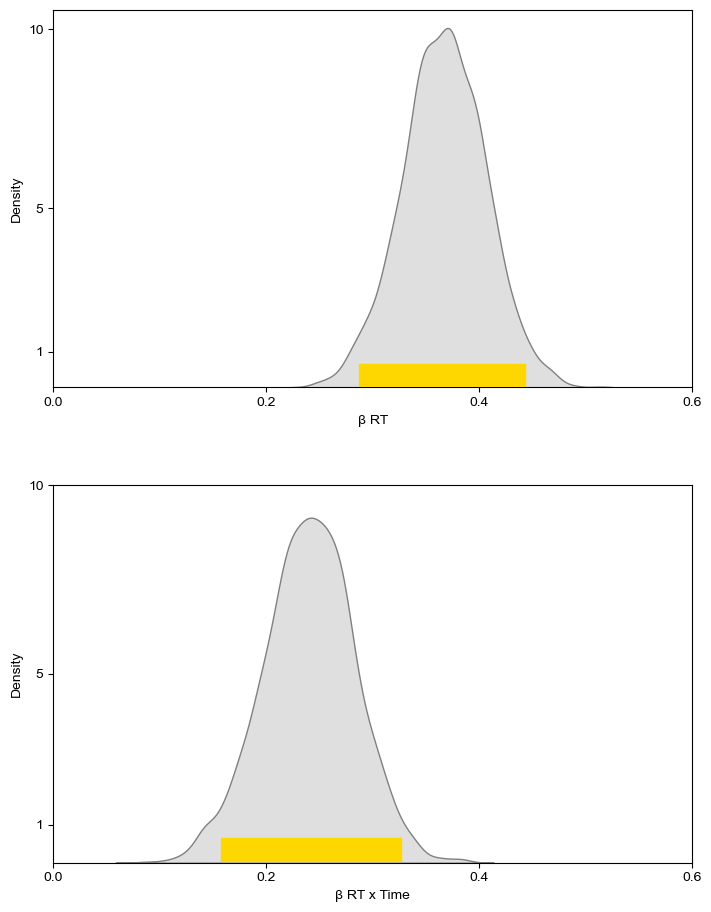

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az

# Assuming 'df1' and 'trace_acc' are defined earlier in your script...
trace_acc = trace3

# Convert subject IDs to indices for group-level parameters
sub_idx, subs = pd.factorize(df['sub'])

# Plotting the posterior distributions on the same grid
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10), sharex=False)

# Increase text size
sns.set(font_scale=3, style='white')

# Extract and plot posterior samples for 'coef_delayed_planning'
posterior_samples = trace_acc.posterior['coef_delayed_planning'].values.flatten()
sns.kdeplot(posterior_samples, shade=True, color="gray", ax=ax1)
hdi = az.hdi(posterior_samples, hdi_prob=0.95)
ax1.add_patch(plt.Rectangle((hdi[0], 0.05), hdi[1] - hdi[0], 0.6, color="gold", zorder=12))
ax1.set_ylabel('Density')
ax1.set_xlabel('\u03B2 RT')  # Set x-axis title
ax1.set_xlim([0, 0.6])  # Set x-axis limits
ax1.set_yticks([1,5,10])  # Set x-axis limits

# Extract and plot posterior samples for 'coef_interaction'
posterior_samples = trace_acc.posterior['coef_interaction'].values.flatten()
sns.kdeplot(posterior_samples, shade=True, color="gray", ax=ax2)
hdi = az.hdi(posterior_samples, hdi_prob=0.95)
ax2.add_patch(plt.Rectangle((hdi[0], 0.05), hdi[1] - hdi[0], 0.6, color="gold", zorder=12))
ax2.set_xlabel('\u03B2 RT x Time')  # Set x-axis title
ax2.set_ylabel('Density')
ax2.set_xlim([0, 0.6])  # Set x-axis limits

ax2.set_yticks([1,5,10])  # Set x-axis limits

# Adjust the space between plots
plt.subplots_adjust(hspace=0.4)
plt.tight_layout()
plt.savefig('posterior_distributions.png', dpi=300, bbox_inches='tight')
plt.show()


                        mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
coef_delayed_planning  0.367  0.039     0.287      0.442      0.001    0.001   
coef_interaction       0.240  0.043     0.158      0.327      0.001    0.001   

                       ess_bulk  ess_tail  r_hat  
coef_delayed_planning    2076.0    2463.0    1.0  
coef_interaction         2156.0     958.0    1.0  
Delayed‐planning vs optimal delay (Spearman): r = 0.7208, p = 0.0000 [Shapiro p-values: x=0.000, y=0.000]


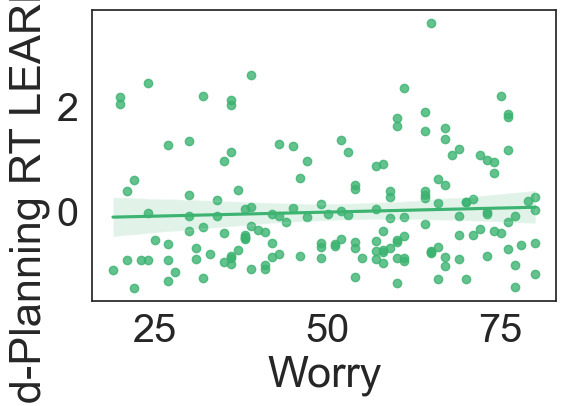


── OLS predicting MB_RT_effect ────────────────────────────────────
                    Robust linear Model Regression Results                    
Dep. Variable:           MB_RT_effect   No. Observations:                  163
Model:                            RLM   Df Residuals:                      155
Method:                          IRLS   Df Model:                            7
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Thu, 03 Jul 2025                                         
Time:                        16:31:24                                         
No. Iterations:                    23                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------

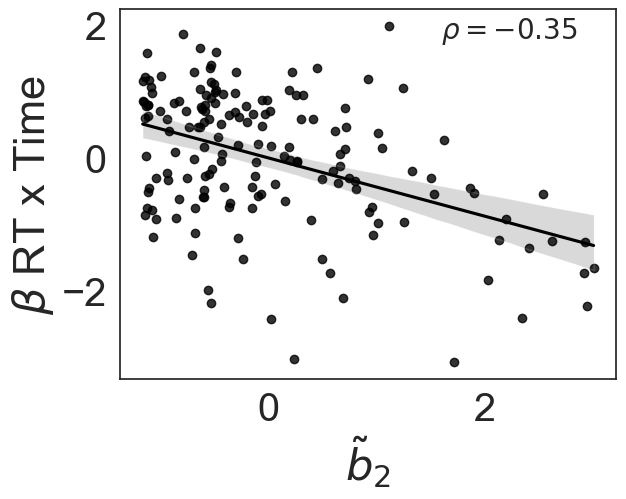

RT effect vs breadth₂ (Spearman): r = 0.5436, p = 0.0000 [Shapiro p-values: x=0.000, y=0.000]


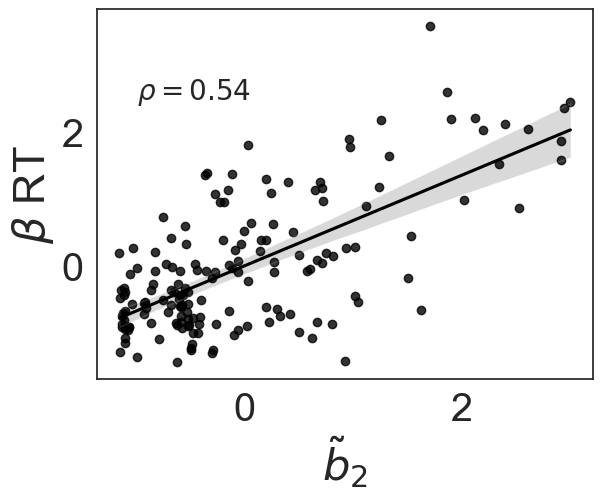

RT effect vs depth (Spearman): r = 0.0840, p = 1.0000 [Shapiro p-values: x=0.000, y=0.000]


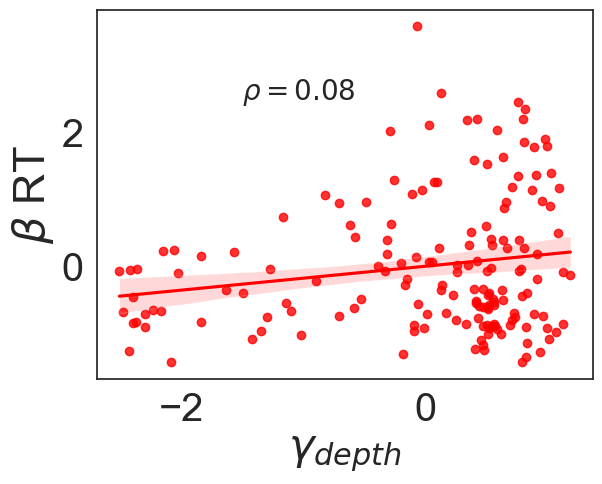

RT effect vs MB_beta (Spearman): r = 0.3326, p = 0.0003 [Shapiro p-values: x=0.000, y=0.003]


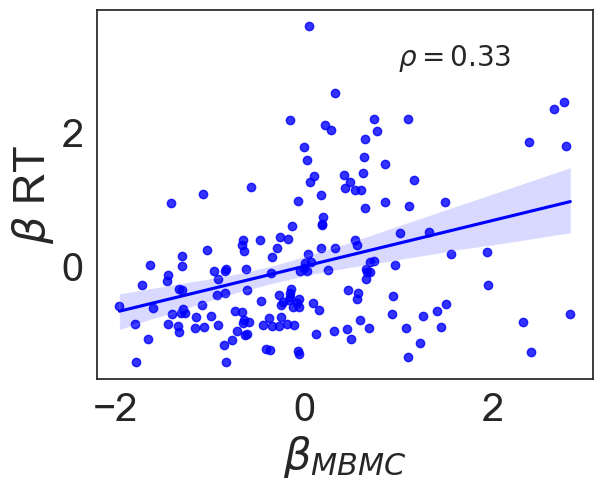

RT effect vs CB (Spearman): r = -0.2423, p = 0.0330 [Shapiro p-values: x=0.000, y=0.035]


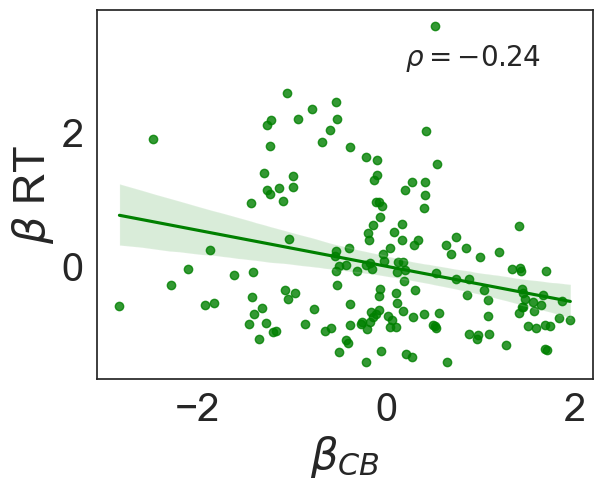

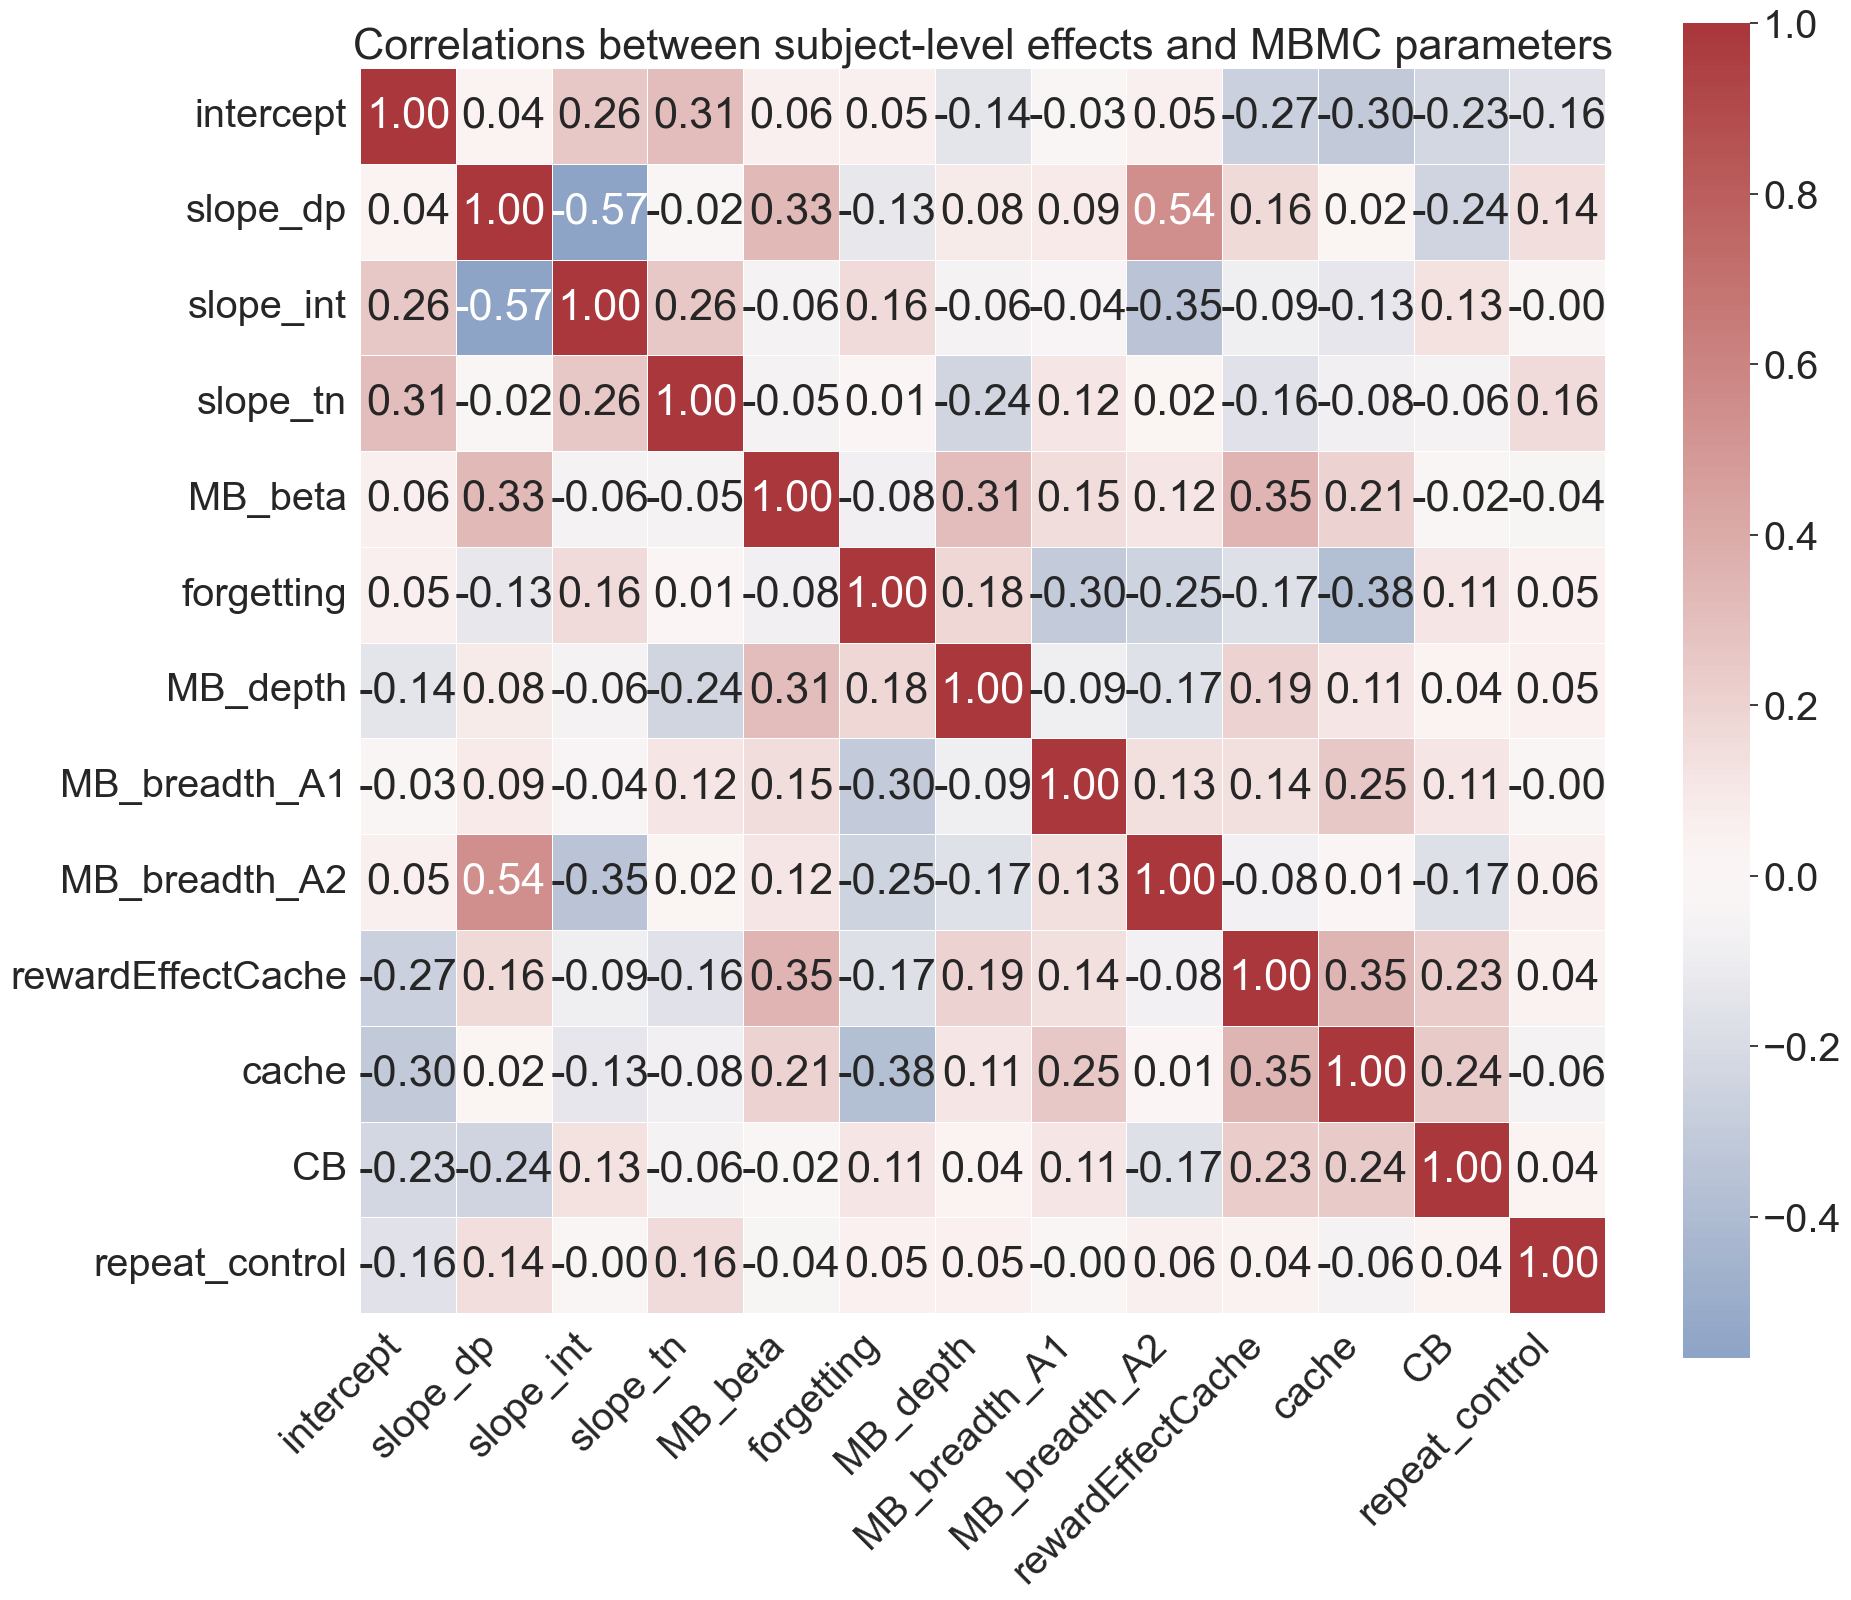

In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az
import statsmodels.api as sm
from scipy.stats import pearsonr, spearmanr, shapiro

# ─── Settings ───────────────────────────────────────────────────────────────
sns.set(font_scale=2.6, style="white")

def normalize_array(x):
    """Z‐score normalize a 1D array or pandas Series."""
    return (x-x.mean())/x.std()

def auto_corr(x, y, alpha=0.05, label=""):
    """
    Test normality of x and y (Shapiro–Wilk).
    If both are normal, use Pearson; otherwise Spearman.
    Prints test used and returns (r, p).
    """
    sx, px = shapiro(x)
    sy, py = shapiro(y)
    method = "Pearson" if (px > alpha and py > alpha) else "Spearman"
    if method == "Pearson":
        r, p = pearsonr(x, y)
        
    else:
        r, p = spearmanr(x, y)

    p=p*18
    p=np.clip(p,0,1)
    print(f"{label} ({method}): r = {r:.4f}, p = {p:.4f}"
          + (f" [Shapiro p-values: x={px:.3f}, y={py:.3f}]" if method=="Spearman" else ""))
    return r, p

# ─── 1. Summarize posterior ─────────────────────────────────────────────────
trace2 = trace3
print(az.summary(trace2, var_names=['coef_delayed_planning', 'coef_interaction'], hdi_prob=0.95))

# ─── 2. Prepare per‐subject random effects & behavioral measures ─────────────
sub_idx, subs = pd.factorize(df['sub'])

# extract & normalize all sub‐level effects in a dict
posterior_means = trace2.posterior.mean(dim=['chain', 'draw'])
effects = {
    'intercept': 'intercept_sub',
    'slope_dp': 'slope_sub_dp',
    'slope_int': 'slope_sub_interaction',
    'slope_tn': 'slope_sub_tn',
}
for name, var in effects.items():
    effects[name] = normalize_array(posterior_means[var].values)

# group‐level means
group = df.groupby('sub')
worry = group['worry'].mean().reindex(subs).values
opt_delay = group['optimally_delayed'].mean().reindex(subs).values
memory = group['percent_correct'].mean().reindex(subs).values
performance = group['got_to_goal'].mean().reindex(subs).values

# ─── 3. Correlation & scatter: delayed‐planning slope vs optimal delay ────────
r, p = auto_corr(effects['slope_dp'], opt_delay,
                  label="Delayed‐planning vs optimal delay")
sns.regplot(x=worry, y=effects['slope_dp'], color='mediumseagreen')
plt.xlabel('Worry')
plt.ylabel('Delayed-Planning RT LEARNING Effect')
plt.tight_layout()
plt.show()

# ─── 4. Load & normalize model parameters ────────────────────────────────────
params = {
    'MB_beta':        np.load('MB_B_exec.npy'),
    'forgetting': np.load('forget_exec.npy'),
    'MB_depth':       np.load('MB_depth_exec.npy'),
    'MB_breadth_A1':  np.load('MB_breadth_exec.npy') * 8,
    'MB_breadth_A2':  np.load('breadth2_exec.npy')   * 4,
    'rewardEffectCache':       np.load('cache_reward_exec.npy'),
    'cache':     np.load('mbcache_exec.npy'),
    'CB':             np.load('cb_exec.npy'),
    'repeat_control':             np.load('cache_plan_exec.npy'),
}


for k, v in params.items():
    params[k] = normalize_array(v)

# ─── 5. Build DataFrame & fit OLS models ─────────────────────────────────────
data = pd.DataFrame({
    'const': 1,
    'MB_RT_effect':  effects['slope_dp'],
    'MB_RT_over_time': effects['slope_int'],
    'RT_sub':         effects['intercept'],
    'worry':          worry,
    'performance':    performance,
    **params
})
features = ['MB_beta','MB_breadth_A1','MB_breadth_A2',
            'MB_depth','CB','rewardEffectCache','cache','forgetting']

for outcome in ['MB_RT_effect', 'MB_RT_over_time', 'RT_sub']:
    print(f"\n── OLS predicting {outcome} ────────────────────────────────────")
    model = sm.RLM(data[outcome], data[features])
    result = model.fit()
    print(result.summary())
    # test correlation with MB_beta
    auto_corr(data[outcome], data['MB_beta'],
              label=f"{outcome} vs MB_beta")

# ─── 6. Additional correlations & plots ──────────────────────────────────────
# correlation RT_over_time vs MB_breadth_A2
r, p = auto_corr(effects['slope_int'], params['MB_breadth_A2'],
                  label="RT x Time vs breadth₂")
print('cache rwd + B RT effect')
r1, p1 = auto_corr(effects['slope_int'], params['rewardEffectCache'],
                  label="RT x Time vs Cache Rwd LR")

sns.regplot(x='MB_breadth_A2', y='MB_RT_over_time', data=data, color='black')
plt.xlabel(r"$\tilde b_2$")
plt.ylabel(r"$\beta$ RT x Time")
plt.text(1.6, 1.8, r"$\rho = {}$".format(round(r,2)), fontsize=20)
plt.savefig('MB_BothAction_RTinteraction.png', dpi=300, bbox_inches='tight')
plt.show()

# correlation RT_effect vs MB_breadth_A2
r, p = auto_corr(effects['slope_dp'], params['MB_breadth_A2'],
                  label="RT effect vs breadth₂")
sns.regplot(x='MB_breadth_A2', y='MB_RT_effect', data=data, color='black')
plt.xlabel(r"$\tilde b_2$")
plt.ylabel(r"$\beta$ RT")
plt.text(-1, 2.5, r"$\rho = {}$".format(round(r,2)), fontsize=20)
plt.savefig('MB_BothAction_RTMAIN.png', dpi=300, bbox_inches='tight')
plt.show()

# depth
r, p = auto_corr(effects['slope_dp'], params['MB_depth'],
                  label="RT effect vs depth")
sns.regplot(x='MB_depth', y='MB_RT_effect', data=data, color='red')
plt.xlabel(r"$\gamma_{depth}$")
plt.ylabel(r"$\beta$ RT")
plt.text(-1.5, 2.5, r"$\rho = {}$".format(round(r,2)), fontsize=20)
plt.savefig('MB_Depth_RTMAIN.png', dpi=300, bbox_inches='tight')
plt.show()

# MB_beta
r, p = auto_corr(effects['slope_dp'], params['MB_beta'],
                  label="RT effect vs MB_beta")
sns.regplot(x='MB_beta', y='MB_RT_effect', data=data, color='blue')
plt.xlabel(r"$\beta_{MBMC}$")
plt.ylabel(r"$\beta$ RT")
plt.text(1, 3, r"$\rho = {}$".format(round(r,2)), fontsize=20)
plt.savefig('MBBeta_RTMAIN.png', dpi=300, bbox_inches='tight')
plt.show()

r, p = auto_corr(effects['slope_dp'], params['CB'],
                  label="RT effect vs CB")
sns.regplot(x='CB', y='MB_RT_effect', data=data, color='green')
plt.xlabel(r"$\beta_{CB}$")
plt.ylabel(r"$\beta$ RT")
plt.text(0.2, 3, r"$\rho = {}$".format(round(r,2)), fontsize=20)
plt.savefig('CB_RTMAIN.png', dpi=300, bbox_inches='tight')
plt.show()

# ─── 7. Combine effects + parameters & visualise correlations ────────────────
cols_effects = ['intercept', 'slope_dp', 'slope_int', 'slope_tn']
effects_df   = pd.DataFrame({k: effects[k] for k in cols_effects})

params_df    = pd.DataFrame(params)           # already z-scored above
combined_df  = pd.concat([effects_df, params_df], axis=1)

# correlation matrix
corr = combined_df.corr(method='spearman')

# heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(
    corr,
    annot=True, fmt=".2f", cmap="vlag", center=0,
    linewidths=.5, square=True, cbar_kws={"shrink": .75}
)
plt.title("Correlations between subject-level effects and MBMC parameters")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("param_effects_corr_heatmap.png", dpi=300)
plt.show()

C:\Users\sharp\AppData\Local\Temp\ipykernel_32384\1571351087.py:43: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, grp in data.groupby('optimally_delayed_choice_bin'):


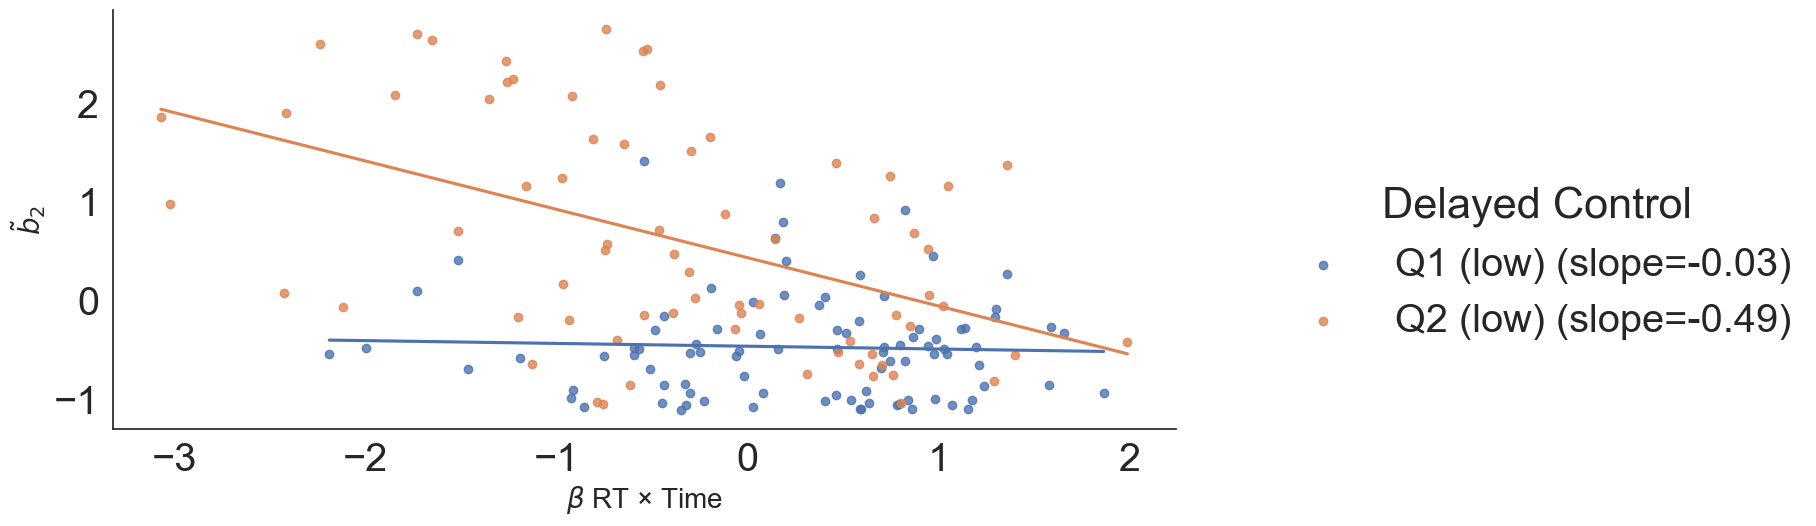

In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd

# 1. get your subject list in the same order as your other vectors
subjects = df['sub'].unique()

# 2. compute per‐subject proportion of optimally_delayed_choice

# 3. build your data frame (now including 'sub' and the new variable)

data2 = {
    'MB_RT_over_time':             effects['slope_int'],
    'MB_RT_effect':                effects['slope_dp'],
    'MB_beta':                     params['MB_beta'],
    'MB_depth':                    params['MB_depth'],
    'MB_breadth_A2':               params['MB_breadth_A2'],
}
data2['optControl'] = df.groupby('sub')['optimally_delayed'].mean().reindex(subjects).values
for k, v in data2.items():
    data2[k] = normalize_array(v)
data = pd.DataFrame({
    'MB_RT_over_time':             data2['MB_RT_over_time'],
    'MB_RT_effect':               data2['MB_RT_effect'],
    'MB_beta':                     data2['MB_beta'],
    'MB_depth':                   data2['MB_depth'],
    'MB_breadth_A2':              data2['MB_breadth_A2'],
    'optimalDelay':              data2['optControl']
})
# # Assuming the data dictionary is already provided
# data=data[mask]

# -- (1) bin & compute slopes as before --
data['optimally_delayed_choice_bin'] = pd.qcut(
    data['optimalDelay'], q=2,
    labels=['Q1 (low)','Q2 (low)']
)

slopes = {}
for name, grp in data.groupby('optimally_delayed_choice_bin'):
    m, _ = np.polyfit(grp['MB_RT_over_time'], grp['MB_breadth_A2'], 1)
    slopes[name] = m

data['optimally_delayed_choice_bin_label'] = data['optimally_delayed_choice_bin'].map(
    lambda x: f"{x} (slope={slopes[x]:.2f})"
)

# -- (2) plot & grab FacetGrid --
g = sns.lmplot(
    x='MB_RT_over_time',
    y='MB_breadth_A2',
    hue='optimally_delayed_choice_bin_label',
    data=data,
    ci=None,
    height=6, aspect=1.2,legend=False
)

# -- (3) make room for legend on the right --
g.fig.subplots_adjust(right=0.75)

# -- (4) move legend outside --
g.add_legend(
    title=r'Delayed Control',
    loc='center left',
    bbox_to_anchor=(1.02, 0.5)
)

# -- (5) labels & show --
plt.xlabel(r'$\beta$ RT × Time', fontsize=20)
plt.ylabel(r"$\tilde b_2$", fontsize=20)
plt.tight_layout()
plt.savefig('effect_plan2breadth_by_OptControlChoiceQuartile.png',dpi=300,bbox_inches='tight')
plt.show()


In [28]:
df3=df[df['planning_depth']==3]
df3_t1=df3[df3['trial_num_within_goal']<=10]
df3_t2=df3[df3['trial_num_within_goal']>=11]

print(df3.columns)
got_to_goal_depth3_change=df3_t2.groupby('sub')['got_to_goal'].sum()-df3_t1.groupby('sub')['got_to_goal'].sum()

got_to_goal_depth3=df3.groupby('sub')['got_to_goal'].sum()
sns.regplot(x='trial_num_within_goal',y='got_to_goal',data=df3,color='brown')
# plt.title('MB  X RT delayed planning')
plt.xlabel('planned well')
plt.ylabel('planning breadth')

# plt.savefig('MBMeta_RTeffect.png',dpi=300,bbox_inches='tight')

plt.show()
X = sm.add_constant(got_to_goal_depth3)  

model = sm.RLM(params['MB_breadth_A1'],X)
result = model.fit()
print(result.summary())

Index(['Unnamed: 0', 'sub', 'trial_num', 'trial_num_within_goal',
       'current_state', 'decision', 'got_to_goal', 'got_to_goal_last',
       'goal_switch', 'control_regressor', 'RT', 'eligible_decisions_accuracy',
       'retrieved_cached', 'planning_depth', 'delayed_planning', 'choices',
       'worry', 'optimally_delayed', 'optimally_control_choice',
       'optimally_delayed_last', 'choice_numeric', 'choice_numeric_last',
       'choices_numeric', 'interaction_won_and_metachoice',
       'got_to_goal_retrieved_cached', 'MB_decision',
       'optimal_metacontrol_choice', 'optimal_metacontrol_choice_accurate',
       'over_planning', 'over_control', 'optimal_metacontrol_choice_last',
       'points_from_choice', 'points_from_goal', 'trial_points',
       'total_points', 'correct_control_action', 'meta_action', 'switch_order',
       'goal_reachability', 'percent_correct', 'bad_planning', 'rawRT',
       'control taking'],
      dtype='object')


                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                  163
Model:                            RLM   Df Residuals:                      161
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Fri, 27 Jun 2025                                         
Time:                        19:22:56                                         
No. Iterations:                    27                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.4567      0.223     -2.045      

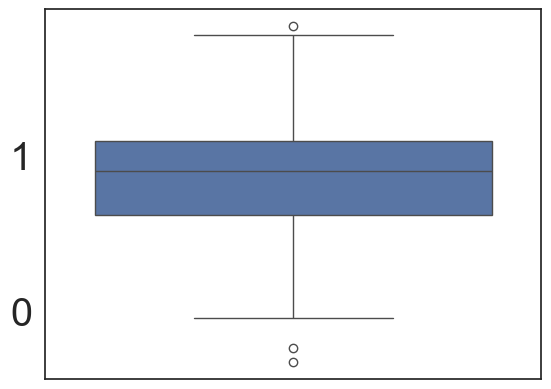

0.845617607488388
0.3735311039891243


In [31]:
x=np.load('reward_effect_revised.npy')
sns.boxplot(x)

plt.show()
print(np.mean(x))
print(np.std(x))